## Imports

In [2]:
import pandas as pd
!pip install adjustText
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from adjustText import adjust_text
import statsmodels.api as sm
import torch
import seaborn as sns
from checkpoint_analysis import load_checkpoint, load_config
from proteo.train import construct_datasets
from proteo.evaluation import get_explainer_baseline

## DATASET STATS

In [3]:
# Load the dataset
file_path = "/scratch/lcornelis/data/data_louisa/raw/merged_dataset_2_22.csv"
data = pd.read_csv(file_path)

# Filter data for patients with HasCSF? == 1 and a value in NFL3_MEAN
filtered_data = data[(data['HasCSF?'] == 1) & (data['NFL3_MEAN'].notna())]

# Initialize a dictionary to store results
results = {}

# Group by Mutation
for mutation, group in filtered_data.groupby('Mutation'):
    sample_size = len(group)
    mean_age = group['AGE_AT_VISIT'].mean()
    std_age = group['AGE_AT_VISIT'].std()
    num_female = group[group['SEX_AT_BIRTH'] == 'F'].shape[0]
    percent_female = (num_female / sample_size) * 100
    
    # Count symptomatic and presymptomatic
    num_symptomatic = group['Gene.Dx'].apply(lambda x: x.endswith('.Sx')).sum()
    num_presymptomatic = group['Gene.Dx'].apply(lambda x: x.endswith('.PreSx')).sum()
    
    # Store results
    results[mutation] = {
        'Sample Size': sample_size,
        'Age, mean (SD)': f"{mean_age:.1f} ({std_age:.1f})",
        'Female, n (%)': f"{num_female} ({percent_female:.0f}%)",
        'Symptomatic': num_symptomatic,
        'Presymptomatic': num_presymptomatic
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Count columns ending with '|PLASMA'
plasma_columns = [col for col in data.columns if col.endswith('|PLASMA')]
num_plasma_columns = len(plasma_columns)

# Print the result
print(f"Number of columns ending with '|CSF': {num_plasma_columns}")

# Display the results
print(results_df)

Number of columns ending with '|CSF': 7289
        Sample Size Age, mean (SD) Female, n (%) Symptomatic Presymptomatic
C9orf72          65    49.0 (13.8)      42 (65%)          30             35
CTL              75    44.7 (12.7)      38 (51%)           0              0
GRN              32    56.4 (13.8)      17 (53%)          16             16
MAPT             52    41.8 (13.3)      28 (54%)          20             32


In [11]:
def process_csv(input_csv: str, output_csv: str):
    # Read the CSV file
    data = pd.read_csv(input_csv)
    
    # Skip the first 4 columns
    data = data.iloc[:, 5:]
    print(data.columns)
    
    # Calculate the mean of each remaining column
    mean_data = data.mean(axis=0)
    
    # Convert the mean data to a DataFrame with column names
    mean_df = mean_data.reset_index()
    mean_df.columns = ['Column Name', 'Mean']
    
    # Save the result to a new CSV file
    mean_df.to_csv(output_csv, index=False)

# Example usage
input_csv = "percent_importances_model=gat-v4,seed=42423_3995_act=sigmoid,adj_thresh=0.7000,batch_size=32,dropout=0.2000,l1_lambda=0.0000,lr=0.0087,lr_scheduler=La_2025-02-05_12-48-31.csv"
output_csv = "cog_slope_mean_importances.csv"
process_csv(input_csv, output_csv)

Index(['NPTX2|P47972|CSF', 'NPTXR|O95502^SL008970@seq.8997.4|CSF',
       'MAP4K1|Q92918|CSF', 'LRFN2|Q9ULH4|CSF',
       'MMP10|P09238^SL000645@seq.8479.4|CSF', 'SERPINB2|P05120|CSF',
       'TMOD2|Q9NZR1|CSF', 'ATP5PF|P18859|CSF',
       'NPTXR|O95502^SL008970@seq.15511.37|CSF',
       'WIF1|Q9Y5W5^SL004652@seq.16070.7|CSF',
       ...
       'PRL|P01236^SL000546@seq.10967.12|CSF', 'KERA|O60938|CSF',
       'MZF1|P28698|CSF', 'CHEK2|O96017^SL003726@seq.3360.50|CSF',
       'ADSL|P30566|CSF', 'SCP2|P22307^SL025946@seq.24293.39|CSF',
       'SNRPE|P62304|CSF', 'CCL13|Q99616|CSF', 'RBBP9|O75884|CSF',
       'OTULIN|Q96BN8|CSF'],
      dtype='object', length=7257)


## Volcano Plot function

In [6]:
def plot_two_volcano(
    importance_csv: str,
    expression_csv: str,
    nfl_data_csv: str,
    outcome_col: str = "NFL3_MEAN",
    top_label_count: int = 12,
    significance_threshold: float = 0.05,
    figsize=(18, 8),
    dpi=150,
    label_fontsize=14,
    title_fontsize=16,
    tick_fontsize=12
):
    """
    Creates two side-by-side volcano plots for a given outcome column:
    1) Colored by mean importance
    2) Colored by DE (combined measure from coefficient & p-value)

    Args:
        importance_csv (str): Path to CSV with importance scores.
        expression_csv (str): Path to CSV with raw expression data (including columns: Mutation, AGE, SEX, etc.).
        nfl_data_csv (str): Path to CSV with the outcome variable(s), e.g. NFL or slope data, aligned by PID.
        outcome_col (str): Which column in nfl_data (and placed into expression_values) to use as the outcome.
        top_label_count (int): Number of top and bottom points to label in each subplot.
        significance_threshold (float): p-value threshold for reference line.
        figsize (tuple): Figure size for the subplots.
        dpi (int): DPI for the figure.

    Returns:
        None (displays a figure with two subplots side by side).
    """
    # --------------------------------------------------------------------
    # 1) Load Data
    # --------------------------------------------------------------------
    # a) Importance scores
    importance_scores = pd.read_csv(importance_csv, index_col=0)
    importance_scores = importance_scores.apply(pd.to_numeric, errors='coerce')

    # b) Expression data
    expression_values = pd.read_csv(expression_csv, index_col=0)

    # c) NFL / slope data, etc.
    nfl_data = pd.read_csv(nfl_data_csv, index_col=0, low_memory=False)
    # Align with expression_values by index
    nfl_data = nfl_data.loc[expression_values.index]

    # d) Convert 'Mutation' col to dummies if it exists
    if 'Mutation' in expression_values.columns:
        expression_values = pd.get_dummies(expression_values, columns=['Mutation'], drop_first=True)
    else:
        print("Warning: 'Mutation' column not found in expression_values.")

    # Ensure the dummy columns exist, even if they're missing
    for col in ['Mutation_CTL', 'Mutation_GRN', 'Mutation_MAPT']:
        if col not in expression_values.columns:
            expression_values[col] = 0
        expression_values[col] = expression_values[col].astype(int)

    # e) Convert SEX from M/F to numeric
    if 'SEX' in expression_values.columns:
        expression_values['SEX'] = expression_values['SEX'].map({'M': 0, 'F': 1})

    # f) Add outcome_col to expression_values
    #    e.g. expression_values["NFL3_MEAN"] = nfl_data["NFL3_MEAN"]
    #    or expression_values["global.ageadj.slope"] = nfl_data["global.ageadj.slope"]
    expression_values[outcome_col] = nfl_data[outcome_col]

    # --------------------------------------------------------------------
    # 2) Prepare the list of common proteins
    # --------------------------------------------------------------------
    protein_columns = importance_scores.columns[4:]  # skip first 4
    common_proteins = [col for col in protein_columns if col in expression_values.columns]
    print(f"Number of proteins present in both DataFrames: {len(common_proteins)}")

    # --------------------------------------------------------------------
    # 3) Compute OLS Coefficients, p-values for each protein
    # --------------------------------------------------------------------
    coefficients = {}
    p_values = {}

    for protein in common_proteins:
        # X: raw predictors (protein + AGE + SEX + Mutation_*).
        covars = ['AGE', 'SEX'] + [c for c in expression_values.columns if c.startswith('Mutation_')]
        cols = [protein] + covars

        X = expression_values[cols].copy()
        y = expression_values[outcome_col].copy()

        # standardize
        X_std = (X - X.mean()) / X.std(ddof=1)
        y_std = (y - y.mean()) / y.std(ddof=1)

        # add intercept
        X_std = sm.add_constant(X_std)

        model = sm.OLS(y_std, X_std).fit()
        coefficients[protein] = model.params[protein]
        p_values[protein] = model.pvalues[protein]

    coef_s = pd.Series(coefficients)
    pval_s = pd.Series(p_values)

    # --------------------------------------------------------------------
    # 4) Compute Mean Importance & DE
    # --------------------------------------------------------------------
    mean_importance = importance_scores[common_proteins].mean(axis=0)

    # DE measure: combine abs(coef) & log(p_value)
    max_coef = coef_s.abs().max()
    min_log_p_value = np.log(pval_s).min()  # negative number
    DE = np.sqrt(
        (coef_s / max_coef) ** 2 +
        (np.log(pval_s) / min_log_p_value) ** 2
    )
    # signed DE
    signed_DE = DE * np.sign(coef_s)

    # --------------------------------------------------------------------
    # 5) Build a DataFrame
    # --------------------------------------------------------------------
    volcano_df = pd.DataFrame({
        'Coefficient': coef_s,
        'P_Value': pval_s,
        'Mean_Importance': mean_importance,
        'DE': signed_DE
    })

    # --------------------------------------------------------------------
    # 6) Plot side-by-side subplots
    # --------------------------------------------------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=dpi)

    # a) Left Plot: color by mean_importance
    # --------------------------------------------------------------------
    ax_left = axes[0]
    # TwoSlopeNorm around 0 for importance
    imp_norm = TwoSlopeNorm(vmin=volcano_df['Mean_Importance'].min(),
                            vcenter=0,
                            vmax=volcano_df['Mean_Importance'].max())

    scatter_left = ax_left.scatter(
        volcano_df['Coefficient'],
        -np.log10(volcano_df['P_Value']),
        c=volcano_df['Mean_Importance'],
        cmap=LinearSegmentedColormap.from_list('custom_cmap', ['blue','white','red']),
        norm=imp_norm,
        alpha=0.6,
        s=30
    )
    column_display_names = {
        "NFL3_MEAN": "NfL",
        # Add other mappings if needed
    }

    # Get the display name for the outcome column
    display_name = column_display_names.get(outcome_col, outcome_col)
    cbar_left = plt.colorbar(scatter_left, ax=ax_left)
    cbar_left.set_label('Mean Importance (%)', fontsize=label_fontsize)

    ax_left.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax_left.axhline(y=-np.log10(significance_threshold), color='red', linestyle='--', alpha=0.5)
    ax_left.set_xlabel(f'Regression Coefficient ({display_name})', fontsize=label_fontsize)
    ax_left.set_ylabel('-log10(p-value)', fontsize=label_fontsize)
    ax_left.set_title(f'Volcano: {display_name} (Colored by Mean Importance (%))', fontsize=title_fontsize)
    ax_left.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # Label top/bottom points by Mean_Importance
    top_positive_imp = volcano_df.nlargest(top_label_count, 'Mean_Importance')
    top_negative_imp = volcano_df.nsmallest(top_label_count, 'Mean_Importance')
    label_df_imp = pd.concat([top_positive_imp, top_negative_imp])

    texts_imp = []
    for i, row in label_df_imp.iterrows():
        prot_name = i.split('|')[0]
        texts_imp.append(ax_left.text(row['Coefficient'], -np.log10(row['P_Value']), prot_name, fontsize=8))
    adjust_text(texts_imp, ax=ax_left, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    ax_left.set_xlim(volcano_df['Coefficient'].min()*1.2, volcano_df['Coefficient'].max()*1.2)
    ax_left.set_ylim(0, 1.1 * -np.log10(volcano_df['P_Value'].min()))
    ax_left.grid(True, alpha=0.3)

    # b) Right Plot: color by DE
    # --------------------------------------------------------------------
    ax_right = axes[1]
    de_norm = TwoSlopeNorm(vmin=volcano_df['DE'].min(),
                           vcenter=0,
                           vmax=volcano_df['DE'].max())

    scatter_right = ax_right.scatter(
        volcano_df['Coefficient'],
        -np.log10(volcano_df['P_Value']),
        c=volcano_df['DE'],
        cmap=LinearSegmentedColormap.from_list('custom_cmap', ['blue','white','red']),
        norm=de_norm,
        alpha=0.6,
        s=30
    )

    cbar_right = plt.colorbar(scatter_right, ax=ax_right)
    cbar_right.set_label('Differential Expression', fontsize=label_fontsize)

    ax_right.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax_right.axhline(y=-np.log10(significance_threshold), color='red', linestyle='--', alpha=0.5)
    ax_right.set_xlabel(f'Regression Coefficient ({display_name})', fontsize=label_fontsize)
    ax_right.set_ylabel('-log10(p-value)', fontsize=label_fontsize)
    ax_right.set_title(f'Volcano: {display_name} (Colored by Differential Expression (%))', fontsize=title_fontsize)
    ax_right.tick_params(axis='both', which='major', labelsize=tick_fontsize)


    # Label top/bottom points by DE
    top_positive_de = volcano_df.nlargest(top_label_count, 'DE')
    top_negative_de = volcano_df.nsmallest(top_label_count, 'DE')
    label_df_de = pd.concat([top_positive_de, top_negative_de])

    texts_de = []
    for i, row in label_df_de.iterrows():
        prot_name = i.split('|')[0]
        texts_de.append(ax_right.text(row['Coefficient'], -np.log10(row['P_Value']), prot_name, fontsize=8))
    adjust_text(texts_de, ax=ax_right, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    ax_right.set_xlim(volcano_df['Coefficient'].min()*1.2, volcano_df['Coefficient'].max()*1.2)
    ax_right.set_ylim(0, 1.1 * -np.log10(volcano_df['P_Value'].min()))
    ax_right.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --------------------------------------------------------------------
    # 7) Print top significant results (example)
    # --------------------------------------------------------------------
    volcano_df['Significant'] = volcano_df['P_Value'] < significance_threshold
    sig_proteins = volcano_df[
        (volcano_df['Significant']) & 
        (volcano_df['Coefficient'].abs() > 0.5)
    ].sort_values('P_Value')
    print(f"\nSignificant proteins for {outcome_col}:")
    print(sig_proteins[['Coefficient', 'P_Value']].head(10))


## Top Protein Comparison

In [9]:
def plot_top_proteins_barplot_from_csv(
    importance_csv: str,
    expression_csv: str,
    nfl_data_csv: str,
    outcome_col: str = "global.ageadj.slope",
    top_n: int = 50,
    skip_cols: int = 4,
    selection_mode: str = "largest",
    fig_title: str = "Proteins by Importance",
    save_filename: str = None
):
    """
    Loads data from CSVs, computes mean importance and DE scores via OLS,
    then plots two horizontal bar charts (DE left, importance right)
    for the top-N proteins, either by largest or smallest importance.
    Protein labels appear only on the left subplot.

    Args:
        importance_csv (str): Path to CSV with importance scores.
        expression_csv (str): Path to raw expression data with columns: Mutation, AGE, SEX, ...
        nfl_data_csv (str): Path to CSV with the outcome (e.g. slope or NFL measure), keyed by PID index.
        outcome_col (str): Which column in nfl_data to use as y-outcome in OLS.
        top_n (int): Number of proteins to display.
        skip_cols (int): Columns to skip in importance_csv before the protein columns.
        selection_mode (str): Either "largest" or "smallest".
                             If "largest", plots the top-N highest importance proteins.
                             If "smallest", plots the bottom-N lowest importance proteins.
        fig_title (str): Title for the entire figure.
        save_filename (str or None): If provided, saves the figure to this file.

    Returns:
        None. Displays a 1×2 matplotlib figure comparing DE vs. importance for the selected proteins.
    """

    # ---------------------------------------------------------------------
    # 1) LOAD & PREPARE DATA
    # ---------------------------------------------------------------------
    importance_scores = pd.read_csv(importance_csv, index_col=0)
    importance_scores = importance_scores.apply(pd.to_numeric, errors='coerce')

    expression_values = pd.read_csv(expression_csv, index_col=0)

    nfl_data = pd.read_csv(nfl_data_csv, index_col=0, low_memory=False)
    # Align by index
    nfl_data = nfl_data.loc[expression_values.index]

    # Convert 'Mutation' to dummies if found
    if 'Mutation' in expression_values.columns:
        expression_values = pd.get_dummies(expression_values, columns=['Mutation'], drop_first=True)
    else:
        print("Warning: 'Mutation' column not found in expression_values.")

    # Ensure dummy columns exist
    for col in ['Mutation_CTL', 'Mutation_GRN', 'Mutation_MAPT']:
        if col not in expression_values.columns:
            expression_values[col] = 0
        expression_values[col] = expression_values[col].astype(int)

    # Encode SEX if present
    if 'SEX' in expression_values.columns:
        expression_values['SEX'] = expression_values['SEX'].map({'M': 0, 'F': 1})

    # Add outcome_col
    expression_values[outcome_col] = nfl_data[outcome_col]

    # ---------------------------------------------------------------------
    # 2) OLS for each protein
    # ---------------------------------------------------------------------
    protein_columns = importance_scores.columns[skip_cols:]
    common_proteins = [p for p in protein_columns if p in expression_values.columns]
    print(f"Number of proteins present in both DataFrames: {len(common_proteins)}")

    coefficients = {}
    p_values = {}

    for protein in common_proteins:
        covars = ['AGE', 'SEX'] + [c for c in expression_values.columns if c.startswith('Mutation_')]
        cols = [protein] + covars

        X = expression_values[cols].copy()
        y = expression_values[outcome_col].copy()

        # Standardize
        X_std = (X - X.mean()) / X.std(ddof=1)
        y_std = (y - y.mean()) / y.std(ddof=1)

        X_std = sm.add_constant(X_std)
        model = sm.OLS(y_std, X_std).fit()

        coefficients[protein] = model.params[protein]
        p_values[protein] = model.pvalues[protein]

    coef_s = pd.Series(coefficients)
    pval_s = pd.Series(p_values)

    # ---------------------------------------------------------------------
    # 3) COMPUTE mean_importance & "signed DE"
    # ---------------------------------------------------------------------
    mean_importance = importance_scores[common_proteins].mean(axis=0)

    # Replace any p=0
    pval_s = pval_s.replace(0, 1e-300)

    max_coef = coef_s.abs().max()
    min_log_p_value = np.log(pval_s).min()  # negative

    # DE measure
    DE = np.sqrt(
        (coef_s / max_coef)**2 +
        (np.log(pval_s) / min_log_p_value)**2
    )
    signed_DE = DE * np.sign(coef_s)

    # ---------------------------------------------------------------------
    # 4) SELECT top-N (largest or smallest) & reorder
    # ---------------------------------------------------------------------
    if selection_mode == "largest":
        selected_proteins = mean_importance.nlargest(top_n).index
        # Sort them descending
        selected_imp = mean_importance.loc[selected_proteins].sort_values(ascending=False)
        color = 'lightcoral'
    elif selection_mode == "smallest":
        selected_proteins = mean_importance.nsmallest(top_n).index
        # Sort them ascending
        selected_imp = mean_importance.loc[selected_proteins].sort_values(ascending=True)
        color = 'skyblue'
    else:
        raise ValueError("selection_mode must be 'largest' or 'smallest'.")

    selected_de = signed_DE.reindex(selected_imp.index)

    # Truncate protein labels at '|'
    short_labels = [prot.split("|")[0] for prot in selected_imp.index]

    # ---------------------------------------------------------------------
    # 5) PLOT side-by-side bar charts (DE left, importance right)
    # ---------------------------------------------------------------------
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 16))

    # LEFT: DE (label on y-axis)
    axes[0].barh(
        y=np.arange(top_n),
        width=selected_de.values,
        color=color,
        alpha=0.8
    )
    axes[0].set_yticks(np.arange(top_n))
    axes[0].set_yticklabels(short_labels, fontsize=16)
    axes[0].invert_yaxis()
    axes[0].set_xlabel("Differential Correlation Score", fontsize=18)
    axes[0].set_title("Differential Correlation Scores", fontsize=18)
    axes[0].tick_params(axis='both', which='major', labelsize=14) 
    if selection_mode == "largest":
        axes[0].invert_xaxis()

    # RIGHT: Importance (no y-axis labels)
    axes[1].barh(
        y=np.arange(top_n),
        width=selected_imp.values,
        color=color,
        alpha=0.8
    )
    axes[1].invert_yaxis()
    axes[1].set_yticks([])
    axes[1].set_xlabel("Mean Importance (%)", fontsize=18)
    axes[1].set_title("Mean Importance Scores (%)", fontsize=18)
    axes[1].tick_params(axis='both', which='major', labelsize=16) 
    if selection_mode == "smallest":
        axes[1].invert_xaxis()

    # Figure title
    mode_text = "Highest" if selection_mode == "largest" else "Lowest"
    fig.suptitle(f"{fig_title} ({mode_text} {top_n})", fontsize=24)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93, wspace=0.2)

    plt.show()

    # ---------------------------------------------------------------------
    # 6) PRINT quick summary
    # ---------------------------------------------------------------------
    sig_mask = (pval_s < 0.05) & (coef_s.abs() > 0.5)
    sig_proteins = pval_s[sig_mask].sort_values()
    print("\nSignificant Proteins (p < 0.05 & |coef| > 0.5):")
    print(sig_proteins.head(5))

## NFL PLOTS

Number of proteins present in both DataFrames: 7258


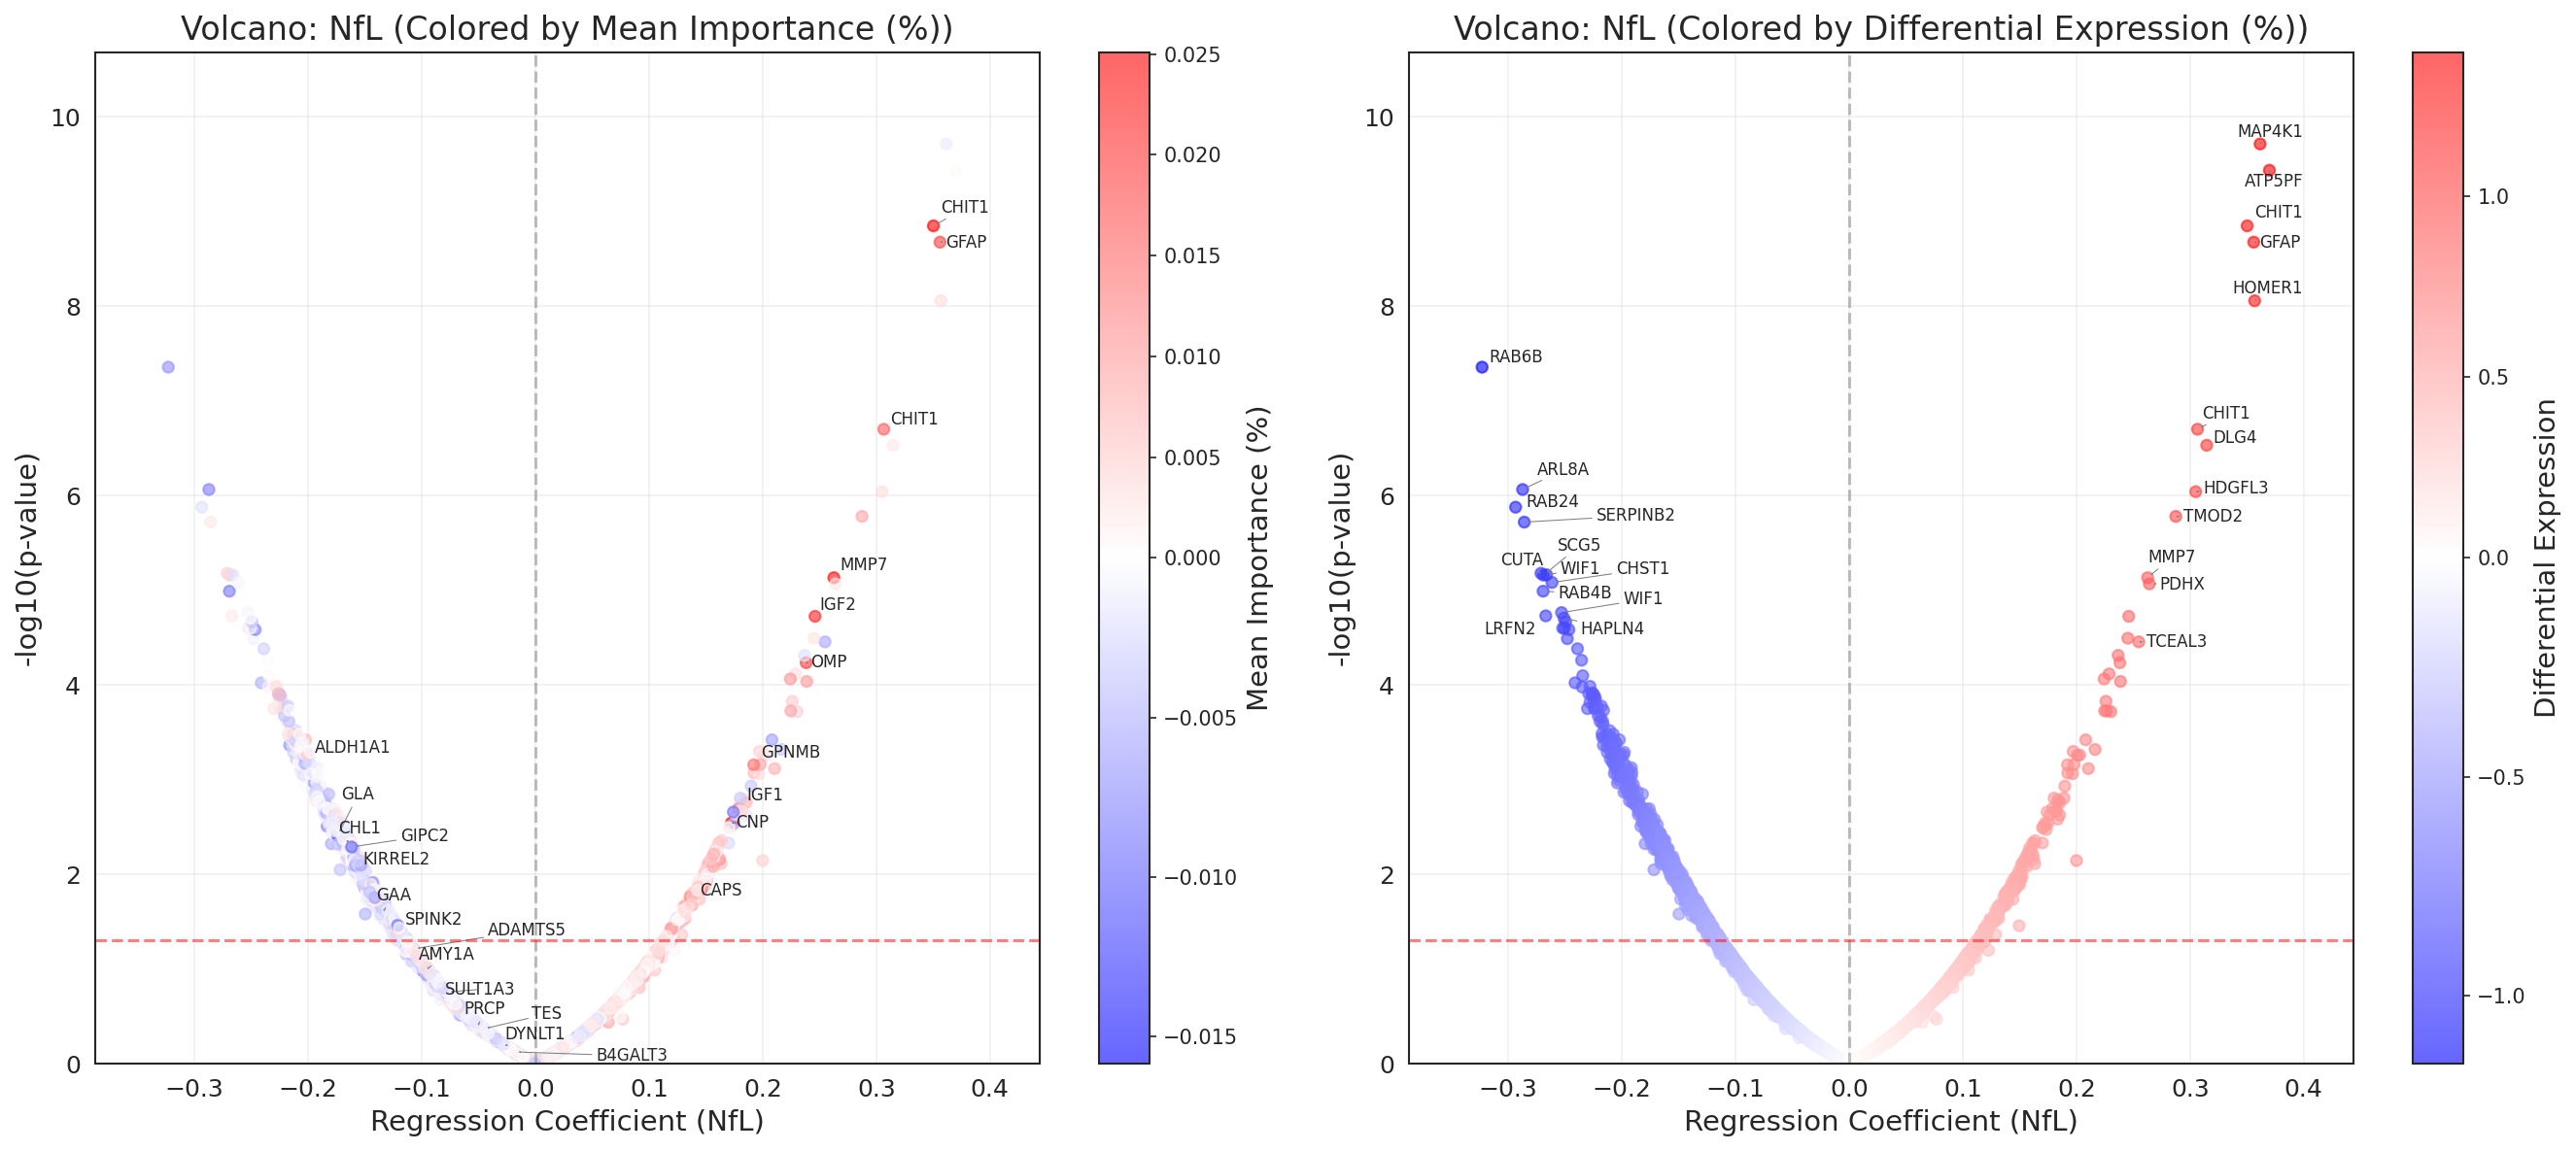


Significant proteins for NFL3_MEAN:
Empty DataFrame
Columns: [Coefficient, P_Value]
Index: []


In [7]:
# For NFL3_MEAN
plot_two_volcano(
    importance_csv="percent_importances_model=gat-v4,seed=47436_511_act=tanh,adj_thresh=0.9000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0001,lr_scheduler=CosineA_2024-10-29_18-37-51.csv",
    expression_csv="raw_expression_nfl.csv",
    nfl_data_csv="/scratch/lcornelis/data/data_louisa/raw/merged_dataset_2_22.csv",
    outcome_col="NFL3_MEAN",
    top_label_count=12
)

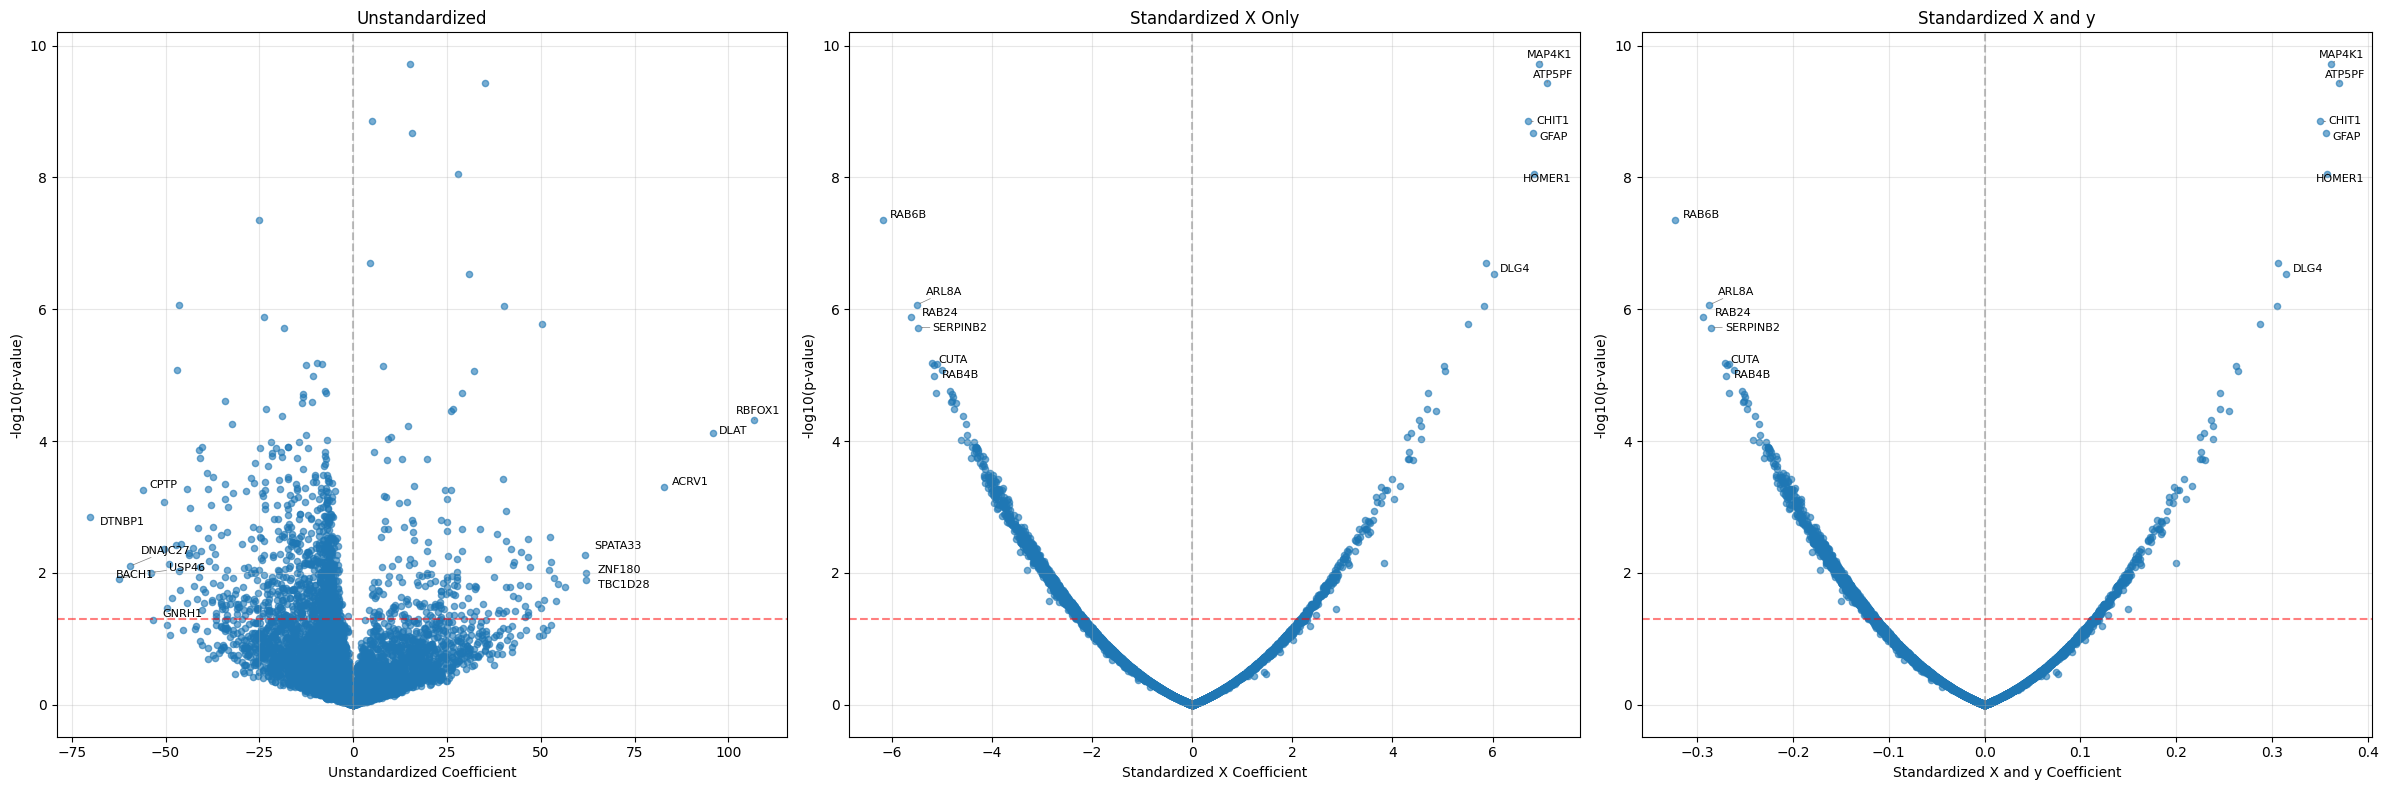


Top significant proteins (Unstandardized):
                                         Coefficient       P_Value
MAP4K1|Q92918|CSF                          15.074642  1.927061e-10
ATP5PF|P18859|CSF                          35.037862  3.655413e-10
GFAP|P14136^SL004271@seq.3034.1|CSF        15.730110  2.100101e-09
HOMER1|Q86YM7^SL015060@seq.19229.92|CSF    27.891990  8.745158e-09
RAB6B|Q9NRW1|CSF                          -25.046004  4.393253e-08
DLG4|P78352|CSF                            30.793868  2.935376e-07
ARL8A|Q96BM9|CSF                          -46.298485  8.616483e-07
HDGFL3|Q9Y3E1|CSF                          40.221226  9.081740e-07
RAB24|Q969Q5|CSF                          -23.874590  1.324328e-06
TMOD2|Q9NZR1|CSF                           50.378646  1.656567e-06

Top significant proteins (Standardized X Only):
                                         Coefficient       P_Value
MAP4K1|Q92918|CSF                           6.924237  1.927061e-10
ATP5PF|P18859|CSF                   

In [9]:
# Keep your data loading code the same up to common_proteins

# Initialize dictionaries for all three versions
coefficients_std_x = {}
p_values_std_x = {}
coefficients_std_xy = {}  
p_values_std_xy = {}
coefficients_unstd = {}
p_values_unstd = {}

# Calculate coefficients for all three versions
for protein in common_proteins:
   # Common setup
   cols = [protein, 'AGE', 'SEX'] + [
       col for col in expression_values.columns
       if col.startswith('Mutation_')
   ]
   X = expression_values[cols].copy()
   y = expression_values['NFL3_MEAN'].copy()
   
   # Version 1: Unstandardized
   X_unstd = sm.add_constant(X)
   model_unstd = sm.OLS(y, X_unstd).fit()
   coefficients_unstd[protein] = model_unstd.params[protein]
   p_values_unstd[protein] = model_unstd.pvalues[protein]
   
   # Version 2: Standardize only X
   X_standardized = (X - X.mean()) / X.std(ddof=1)
   X_standardized = sm.add_constant(X_standardized)
   model_std_x = sm.OLS(y, X_standardized).fit()
   coefficients_std_x[protein] = model_std_x.params[protein]
   p_values_std_x[protein] = model_std_x.pvalues[protein]
   
   # Version 3: Standardize both X and y
   X_standardized = (X - X.mean()) / X.std(ddof=1)
   y_standardized = (y - y.mean()) / y.std(ddof=1)
   X_standardized = sm.add_constant(X_standardized)
   model_std_xy = sm.OLS(y_standardized, X_standardized).fit()
   coefficients_std_xy[protein] = model_std_xy.params[protein]
   p_values_std_xy[protein] = model_std_xy.pvalues[protein]

# Create DataFrames for all versions
volcano_df_unstd = pd.DataFrame({
   'Coefficient': pd.Series(coefficients_unstd),
   'P_Value': pd.Series(p_values_unstd)
})

volcano_df_std_x = pd.DataFrame({
   'Coefficient': pd.Series(coefficients_std_x),
   'P_Value': pd.Series(p_values_std_x)
})

volcano_df_std_xy = pd.DataFrame({
   'Coefficient': pd.Series(coefficients_std_xy),
   'P_Value': pd.Series(p_values_std_xy)
})

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

# Plot unstandardized version
scatter1 = ax1.scatter(
   volcano_df_unstd['Coefficient'],
   -np.log10(volcano_df_unstd['P_Value']),
   alpha=0.6,
   s=20
)

# Label top proteins in unstandardized plot
texts1 = []
top_proteins_unstd = pd.concat([
   volcano_df_unstd.nlargest(6, 'Coefficient'),
   volcano_df_unstd.nsmallest(6, 'Coefficient')
])

for i, row in top_proteins_unstd.iterrows():
   protein_name = i.split('|')[0]
   texts1.append(ax1.text(row['Coefficient'], 
                         -np.log10(row['P_Value']), 
                         protein_name, 
                         fontsize=8))

# Plot standardized X version
scatter2 = ax2.scatter(
   volcano_df_std_x['Coefficient'],
   -np.log10(volcano_df_std_x['P_Value']),
   alpha=0.6,
   s=20
)

# Label top proteins in standardized X plot
texts2 = []
top_proteins_std_x = pd.concat([
   volcano_df_std_x.nlargest(6, 'Coefficient'),
   volcano_df_std_x.nsmallest(6, 'Coefficient')
])

for i, row in top_proteins_std_x.iterrows():
   protein_name = i.split('|')[0]
   texts2.append(ax2.text(row['Coefficient'], 
                         -np.log10(row['P_Value']), 
                         protein_name, 
                         fontsize=8))

# Plot standardized X and y version
scatter3 = ax3.scatter(
   volcano_df_std_xy['Coefficient'],
   -np.log10(volcano_df_std_xy['P_Value']),
   alpha=0.6,
   s=20
)

# Label top proteins in standardized X and y plot
texts3 = []
top_proteins_std_xy = pd.concat([
   volcano_df_std_xy.nlargest(6, 'Coefficient'),
   volcano_df_std_xy.nsmallest(6, 'Coefficient')
])

for i, row in top_proteins_std_xy.iterrows():
   protein_name = i.split('|')[0]
   texts3.append(ax3.text(row['Coefficient'], 
                         -np.log10(row['P_Value']), 
                         protein_name, 
                         fontsize=8))

# Adjust text for all plots
adjust_text(texts1, ax=ax1, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
adjust_text(texts2, ax=ax2, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
adjust_text(texts3, ax=ax3, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

# Add reference lines and labels for unstandardized plot
ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax1.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
ax1.set_xlabel('Unstandardized Coefficient')
ax1.set_ylabel('-log10(p-value)')
ax1.set_title('Unstandardized')
ax1.grid(True, alpha=0.3)

# Add reference lines and labels for standardized X plot
ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
ax2.set_xlabel('Standardized X Coefficient')
ax2.set_ylabel('-log10(p-value)')
ax2.set_title('Standardized X Only')
ax2.grid(True, alpha=0.3)

# Add reference lines and labels for standardized X and y plot
ax3.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.5)
ax3.set_xlabel('Standardized X and y Coefficient')
ax3.set_ylabel('-log10(p-value)')
ax3.set_title('Standardized X and y')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print significant results for all versions
significant_threshold = 0.05

print("\nTop significant proteins (Unstandardized):")
significant_unstd = volcano_df_unstd[
   (volcano_df_unstd['P_Value'] < significant_threshold) & 
   (abs(volcano_df_unstd['Coefficient']) > volcano_df_unstd['Coefficient'].std())
].sort_values('P_Value')
print(significant_unstd[['Coefficient', 'P_Value']].head(10))

print("\nTop significant proteins (Standardized X Only):")
significant_std_x = volcano_df_std_x[
   (volcano_df_std_x['P_Value'] < significant_threshold) & 
   (abs(volcano_df_std_x['Coefficient']) > volcano_df_std_x['Coefficient'].std())
].sort_values('P_Value')
print(significant_std_x[['Coefficient', 'P_Value']].head(10))

print("\nTop significant proteins (Standardized X and y):")
significant_std_xy = volcano_df_std_xy[
   (volcano_df_std_xy['P_Value'] < significant_threshold) & 
   (abs(volcano_df_std_xy['Coefficient']) > volcano_df_std_xy['Coefficient'].std())
].sort_values('P_Value')
print(significant_std_xy[['Coefficient', 'P_Value']].head(10))

Number of proteins present in both DataFrames: 7258


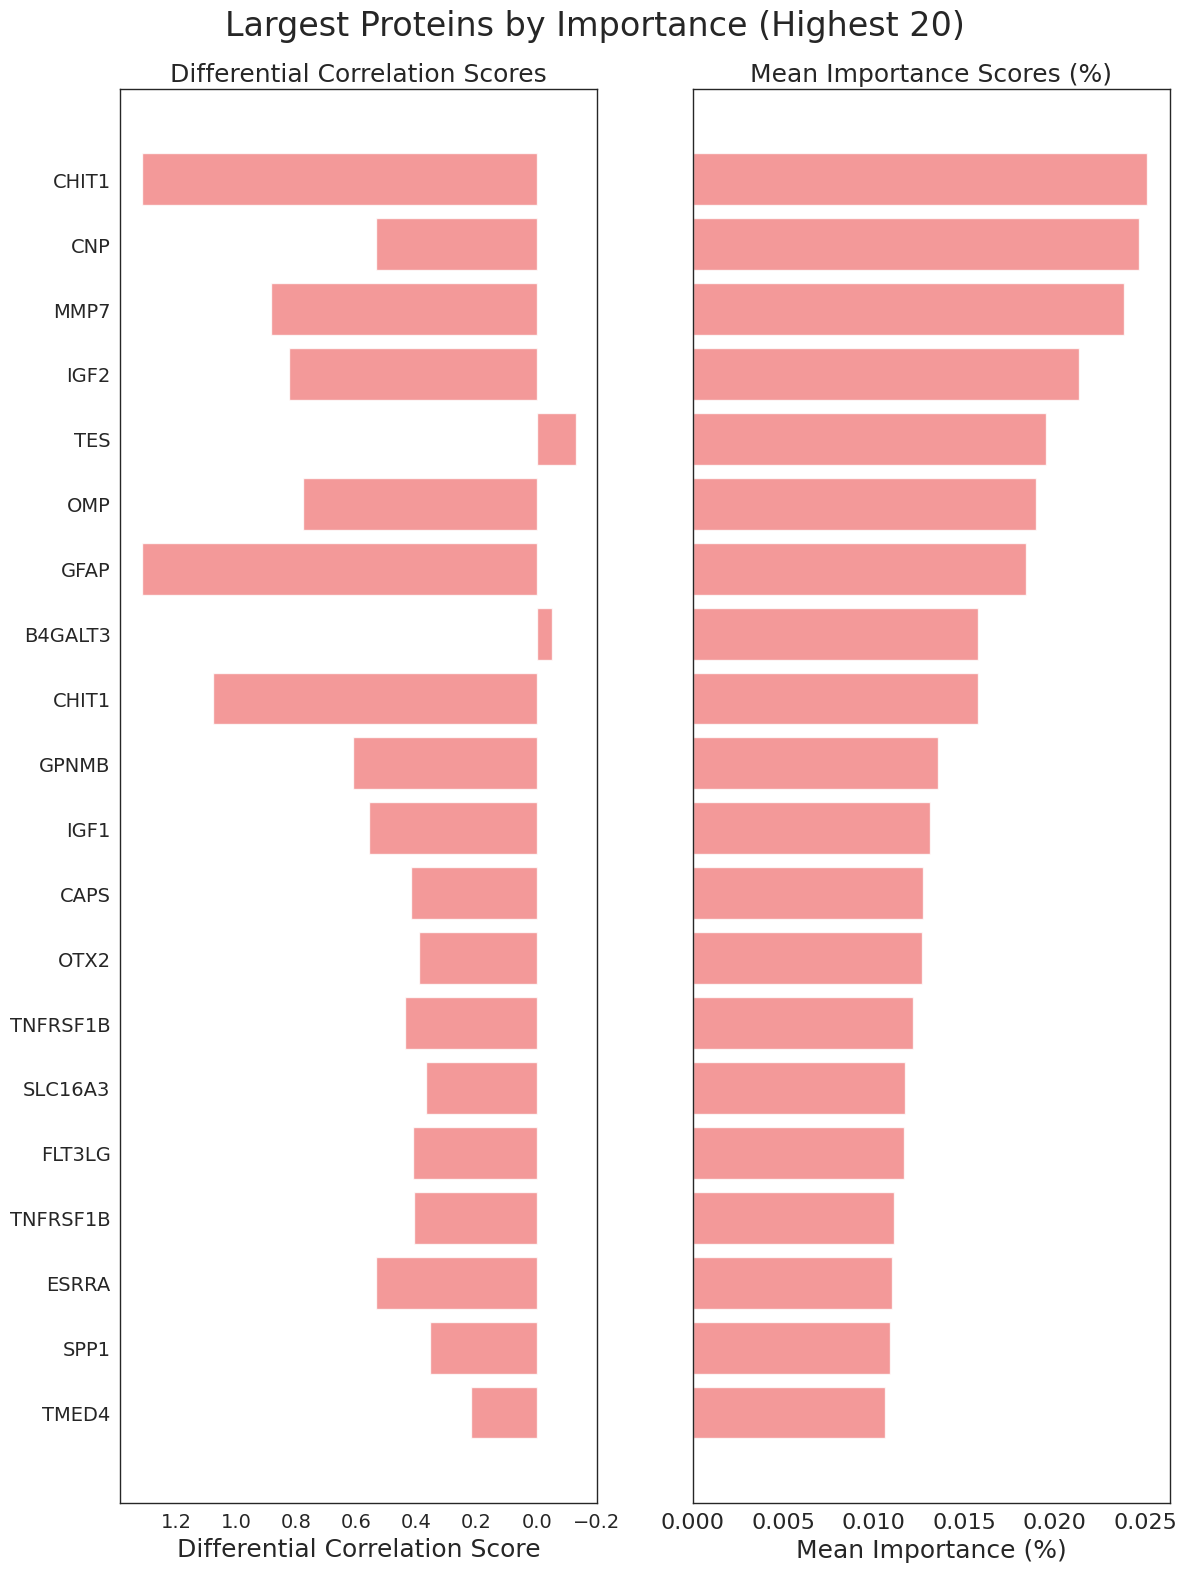


Significant Proteins (p < 0.05 & |coef| > 0.5):
Series([], dtype: float64)


In [10]:
plot_top_proteins_barplot_from_csv(
    importance_csv="percent_importances_model=gat-v4,seed=47436_511_act=tanh,adj_thresh=0.9000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0001,lr_scheduler=CosineA_2024-10-29_18-37-51.csv",
    expression_csv="raw_expression_nfl.csv",
    nfl_data_csv="/scratch/lcornelis/data/data_louisa/raw/merged_dataset_2_22.csv",
    outcome_col="NFL3_MEAN",
    top_n=20,
    skip_cols=4,
    selection_mode="largest",
    fig_title="Largest Proteins by Importance",
)

Number of proteins present in both DataFrames: 7258


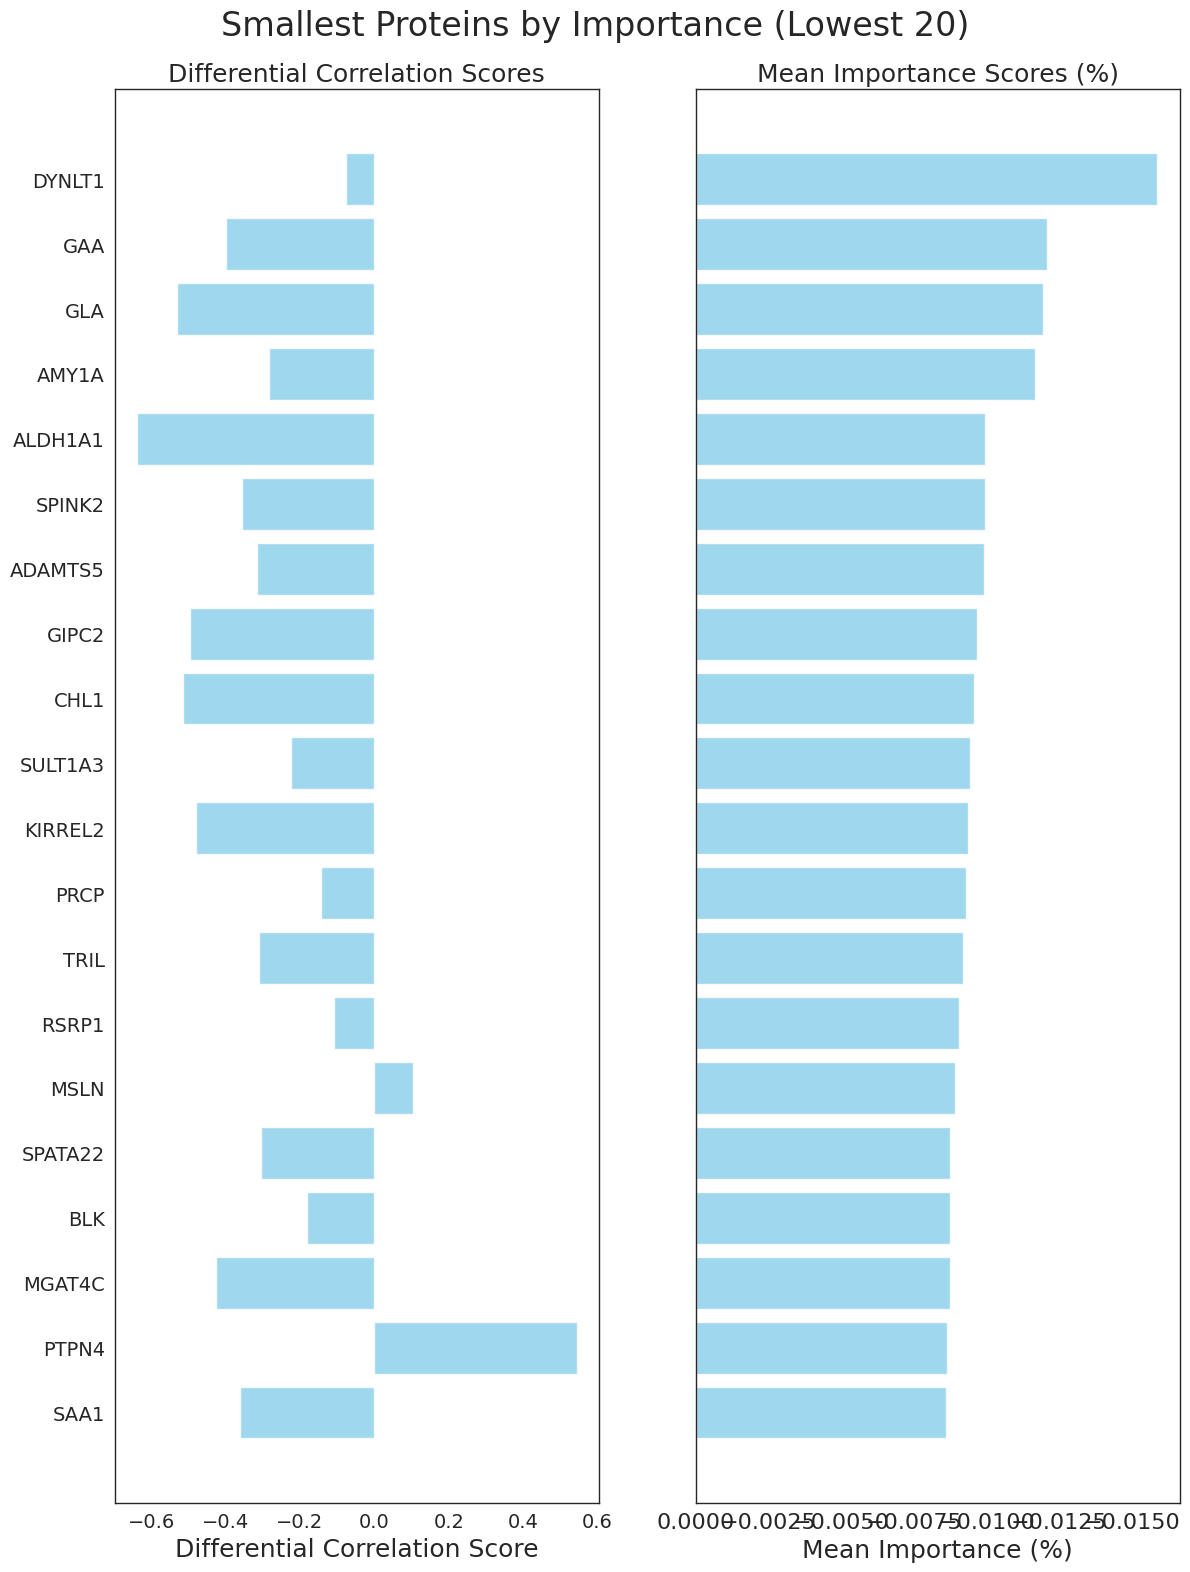


Significant Proteins (p < 0.05 & |coef| > 0.5):
Series([], dtype: float64)


In [11]:
plot_top_proteins_barplot_from_csv(
    importance_csv="percent_importances_model=gat-v4,seed=47436_511_act=tanh,adj_thresh=0.9000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0001,lr_scheduler=CosineA_2024-10-29_18-37-51.csv",
    expression_csv="raw_expression_nfl.csv",
    nfl_data_csv="/scratch/lcornelis/data/data_louisa/raw/merged_dataset_2_22.csv",
    outcome_col="NFL3_MEAN",
    top_n=20,
    skip_cols=4,
    selection_mode="smallest",
    fig_title="Smallest Proteins by Importance",
)

## GLOBAL AGE PLOTS

Number of proteins present in both DataFrames: 7257


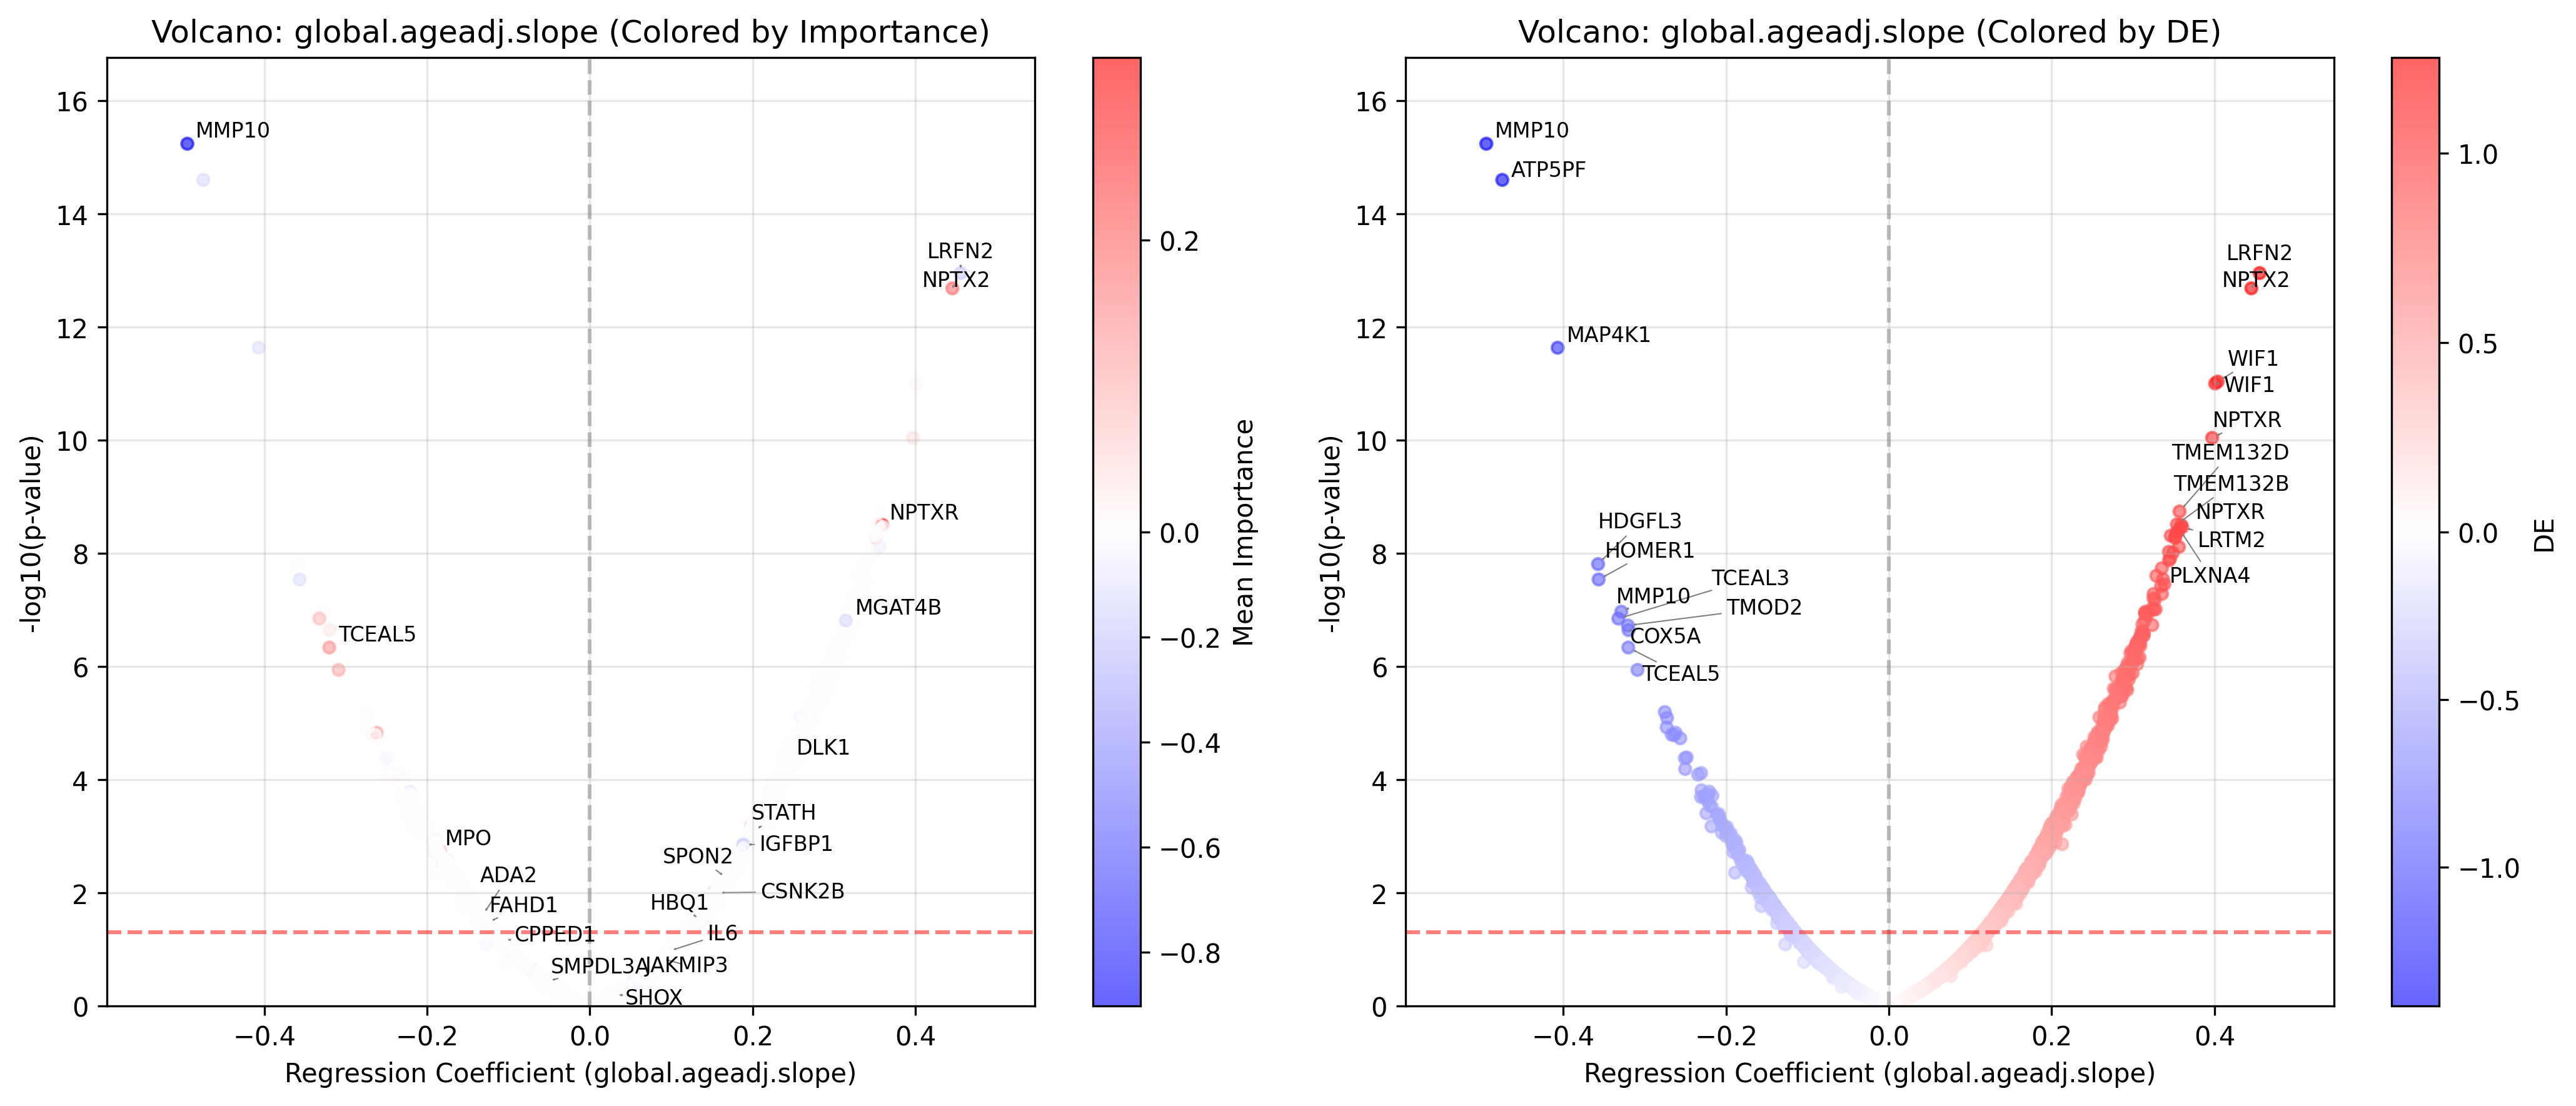


Significant proteins for global.ageadj.slope:
Empty DataFrame
Columns: [Coefficient, P_Value]
Index: []


In [17]:
plot_two_volcano(
    importance_csv="percent_importances_model=gat-v4,seed=42423_3995_act=sigmoid,adj_thresh=0.7000,batch_size=32,dropout=0.2000,l1_lambda=0.0000,lr=0.0087,lr_scheduler=La_2025-02-05_12-48-31.csv",
    expression_csv="raw_expression_global_age.csv",
    nfl_data_csv="/scratch/lcornelis/data/data_louisa/raw/merged_dataset_2_22.csv",
    outcome_col="global.ageadj.slope",
    top_label_count=10,          # Label top-10 and bottom-10
    significance_threshold=0.05, # Horizontal line at p=0.05             # Figure size
    dpi=300                      # High-resolution output
)

Number of proteins present in both DataFrames: 7257


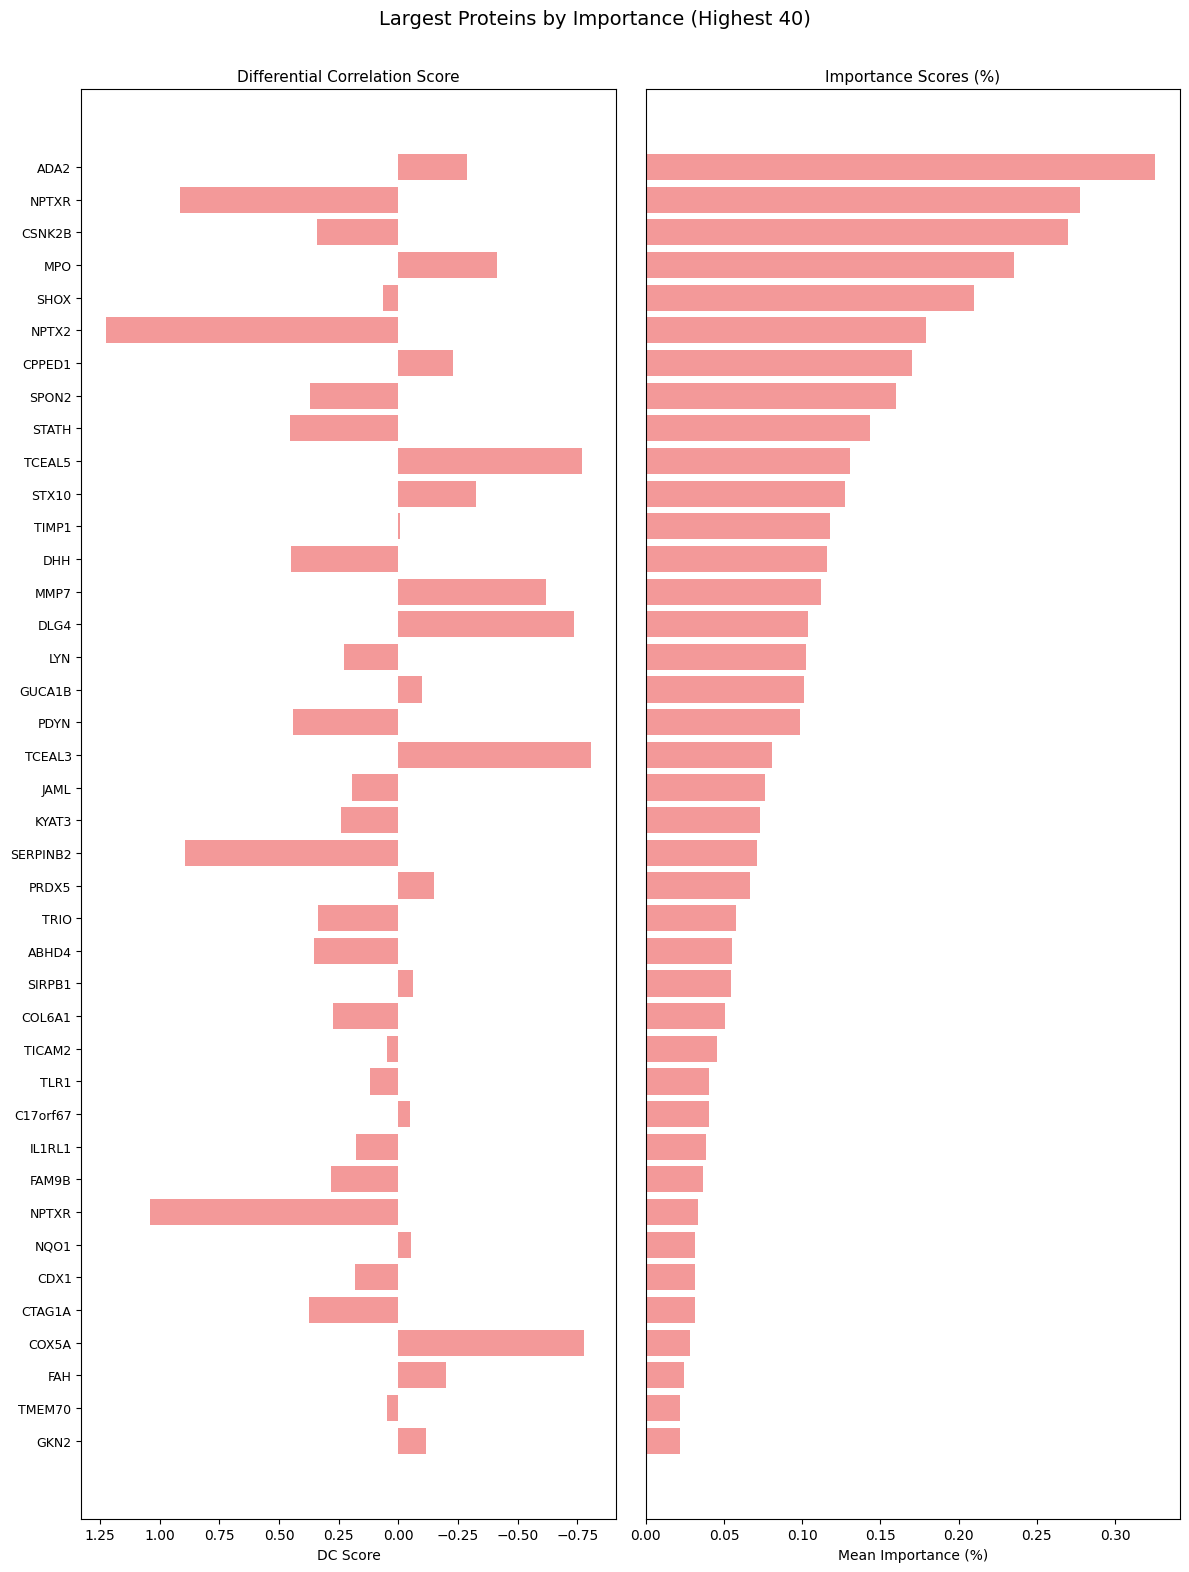


Significant Proteins (p < 0.05 & |coef| > 0.5):
Series([], dtype: float64)


In [43]:
plot_top_proteins_barplot_from_csv(
    importance_csv="percent_importances_model=gat-v4,seed=42423_3995_act=sigmoid,adj_thresh=0.7000,batch_size=32,dropout=0.2000,l1_lambda=0.0000,lr=0.0087,lr_scheduler=La_2025-02-05_12-48-31.csv",
    expression_csv="raw_expression_global_age.csv",
    nfl_data_csv="/scratch/lcornelis/data/data_louisa/raw/merged_dataset_2_22.csv",
    outcome_col="global.ageadj.slope",
    top_n=20,
    skip_cols=4,
    selection_mode="largest",
    fig_title="Largest Proteins by Importance",
)

Number of proteins present in both DataFrames: 7257


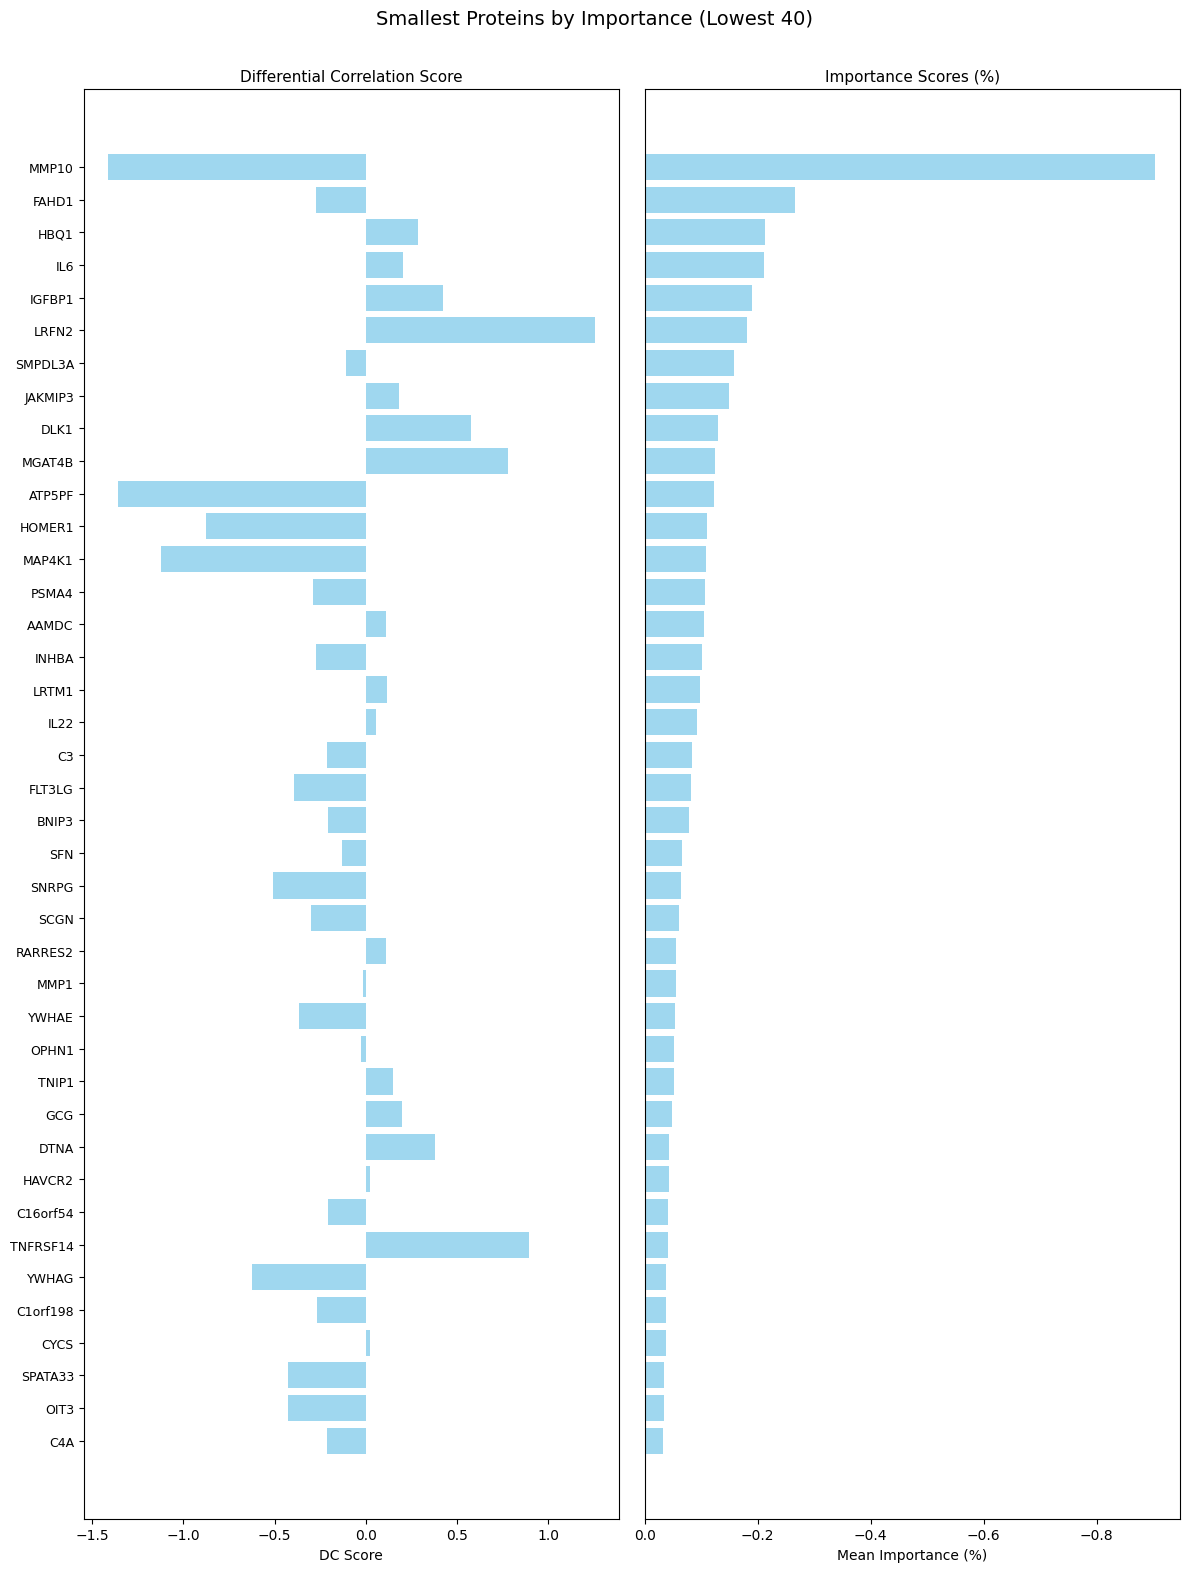


Significant Proteins (p < 0.05 & |coef| > 0.5):
Series([], dtype: float64)


In [44]:
plot_top_proteins_barplot_from_csv(
    importance_csv="percent_importances_model=gat-v4,seed=42423_3995_act=sigmoid,adj_thresh=0.7000,batch_size=32,dropout=0.2000,l1_lambda=0.0000,lr=0.0087,lr_scheduler=La_2025-02-05_12-48-31.csv",
    expression_csv="raw_expression_global_age.csv",
    nfl_data_csv="/scratch/lcornelis/data/data_louisa/raw/merged_dataset_2_22.csv",
    outcome_col="global.ageadj.slope",
    top_n=40,
    skip_cols=4,
    selection_mode="smallest",
    fig_title="Smallest Proteins by Importance",
)

## Integrated Gradients Vis

In [7]:
def compute_gradients_and_cumulative(checkpoint_path, steps=50):
    """
    Computes the gradients and cumulative sum of gradients along the interpolation path.

    Args:
        checkpoint_path (str): Path to the model checkpoint.
        steps (int): Number of interpolation steps.

    Returns:
        alphas (torch.Tensor): Interpolation coefficients (from 0 to 1).
        gradients_tensor (torch.Tensor): Raw gradients for each feature at each step.
        cumulative_gradients (torch.Tensor): Cumulative sum of gradients for each feature at each step.
        outputs (torch.Tensor): Model output for each interpolation step.
    """
    import torch

    # 1) Load the model and dataset
    module = load_checkpoint(checkpoint_path)
    config = load_config(module)
    model = module.model
    model.eval()

    train_dataset, test_dataset = construct_datasets(config)
    participant_data = test_dataset[0]
    input_sample = participant_data.x
    baseline, _ = get_explainer_baseline(config)
    baseline = baseline.unsqueeze(1)
    # print("First 10 values of baseline: ", baseline[:10])
    print("baseline shape: ", baseline.shape)
    # baseline = torch.tensor(baseline, dtype=torch.float32)
    # print("baseline shape: ", baseline.shape)   
    #baseline = torch.zeros_like(input_sample)
    #print("baseline shape: ", baseline.shape)

    # 2) Create interpolation coefficients and initialize placeholders
    alphas = torch.linspace(0.0, 1.0, steps)
    gradients_list = []
    outputs = []

    for alpha in alphas:
        # Interpolate input
        interpolated_x = baseline + alpha * (input_sample - baseline)
        interpolated_x.requires_grad_(True)

        # Forward pass
        output = model(interpolated_x, edge_index=participant_data.edge_index, data=participant_data)
        if isinstance(output, tuple):
            output = output[0]
        if output.dim() > 0:
            output = output.squeeze()
        outputs.append(output.item())

        # Backward pass to compute gradients
        model.zero_grad()
        output.backward(retain_graph=True)
        gradients_list.append(interpolated_x.grad.detach().clone().squeeze(0))

    # Stack gradients into a tensor
    gradients_tensor = torch.stack(gradients_list)  # Shape: [steps, feature_dim]
    gradients_tensor = gradients_tensor.squeeze(-1)

    # Compute cumulative gradients using the trapezoidal rule
    cumulative_gradients = torch.cumsum(gradients_tensor * (alphas[1] - alphas[0]), dim=0)  # Shape: [steps, feature_dim]

    return alphas, gradients_tensor, cumulative_gradients, torch.tensor(outputs)

In [3]:
def plot_gradients_line_plot(alphas, gradients_tensor, cumulative_gradients, outputs, selected_features):
    # --- Visualization Option 1: Line Plot for Selected Features ---
    # Choose a few feature indices to visualize (e.g. features 0, 10, and 20).
    plt.figure(figsize=(10, 6))
    for idx in selected_features:
        plt.plot(alphas.numpy(), gradients_tensor[:, idx].numpy(), 
                 label=f'Feature {idx}')
    
    plt.xlabel('Interpolation Coefficient (Alpha)')
    plt.ylabel('Gradient Value')
    plt.title('Gradient Along the Path from Baseline to Input (Selected Features)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Filter alphas and gradients up to 0.5
    max_alpha = 0.1
    mask = alphas <= max_alpha
    filtered_alphas = alphas[mask]
    filtered_gradients = gradients_tensor[mask]

    # 2) Plot Mean Cumulative Gradients Across All Features
    mean_cumulative_gradients = cumulative_gradients.mean(dim=1)  # Average across all features
    plt.figure(figsize=(10, 6))
    plt.plot(alphas.numpy(), mean_cumulative_gradients.numpy(), label="Mean Cumulative Gradients")
    plt.xlabel("Interpolation Constant (Alpha)")
    plt.ylabel("Mean Cumulative Sum of Gradients")
    plt.title("Mean Cumulative Gradients vs. Alpha")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Visualization Option 2: Plot of Outputs ---
    plt.figure(figsize=(10, 6))
    plt.plot(alphas.numpy(), outputs.numpy(), label='Model Output')
    plt.xlabel('Interpolation Coefficient (Alpha)')
    plt.ylabel('Model Output')
    plt.title('Model Output Along the Interpolation Path')
    plt.grid(True)
    plt.show()

    # --- Visualization Option 1: Line Plot for Selected Features ---
    plt.figure(figsize=(10, 6))
    for idx in selected_features:
        plt.plot(filtered_alphas.numpy(), filtered_gradients[:, idx].numpy(), 
                 label=f'Feature {idx}')
    
    plt.xlabel('Interpolation Coefficient (Alpha)')
    plt.ylabel('Gradient Value')
    plt.title('Gradient Along the Path from Baseline to Input (Selected Features)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot gradients for selected features
    ax1 = plt.gca()
    for idx in selected_features:
        ax1.plot(alphas.numpy(), gradients_tensor[:, idx].numpy(), label=f'Feature {idx}', color='blue')
    
    ax1.set_xlabel('Alphas')
    ax1.set_ylabel('Gradients', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)
    
    # Create a secondary y-axis for the model output
    ax2 = ax1.twinx()
    ax2.plot(alphas.numpy(), outputs.numpy(), label='Model Output', color='orange')
    ax2.set_ylabel('Model Output', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    plt.title('Gradients and Model Output Along the Interpolation Path')
    plt.show()
    

    # 3) Optional: Heatmap of Cumulative Gradients (Subset of Features)
    plt.figure(figsize=(12, 8))
    features_to_show = range(12)  # Adjust this range to show a specific subset of features
    heatmap_data = cumulative_gradients[:, features_to_show].numpy()
    sns.heatmap(
        heatmap_data.T, cmap="viridis",
        xticklabels=np.round(alphas.numpy(), 2), yticklabels=features_to_show
    )
    plt.xlabel("Interpolation Steps (Alpha)")
    plt.ylabel("Feature Index")
    plt.title("Cumulative Gradients Heatmap (Subset of Features)")
    plt.show()

## Global Age Integrated Gradients

In [9]:
checkpoint_path_global_age = (
    "/scratch/lcornelis/outputs/ray_results/"
    "TorchTrainer_2025-02-03_16-34-34/model=gat-v4,seed=42423_3995_act=sigmoid,"
    "adj_thresh=0.7000,batch_size=32,dropout=0.2000,l1_lambda=0.0000,lr=0.0087,"
    "lr_scheduler=La_2025-02-05_12-48-31/checkpoint_000631"
)
alphas, gradients_tensor, cumulative_gradients, outputs = compute_gradients_and_cumulative(checkpoint_path_global_age, steps=100)

Loading datasets from /scratch/lcornelis/data/data_louisa
Absolute path: /scratch/lcornelis/data/data_louisa
Directory contents: ['processed', 'raw']
Processed file names: ['ftd_y_val_global_cog_slope_adj_thresh_0.7_num_nodes_7257_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_train_nolog_random_state_42.pt', 'ftd_y_val_global_cog_slope_adj_thresh_0.7_num_nodes_7257_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_test_nolog_random_state_42.pt']
Loading data from: /scratch/lcornelis/data/data_louisa/processed/ftd_y_val_global_cog_slope_adj_thresh_0.7_num_nodes_7257_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_train_nolog_random_state_42.pt
Train dataset loaded successfully
Processed file names: ['ftd_y_val_global_cog_slope_adj_thresh_0.7_num_nodes_7257_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_train_nolog_random_state_42.pt', 'ftd_y_val_global_cog_slope_a

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

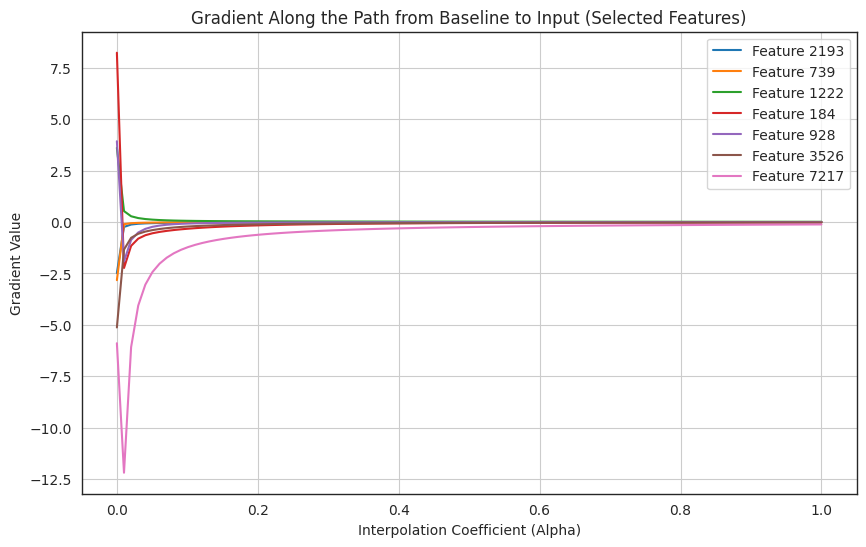

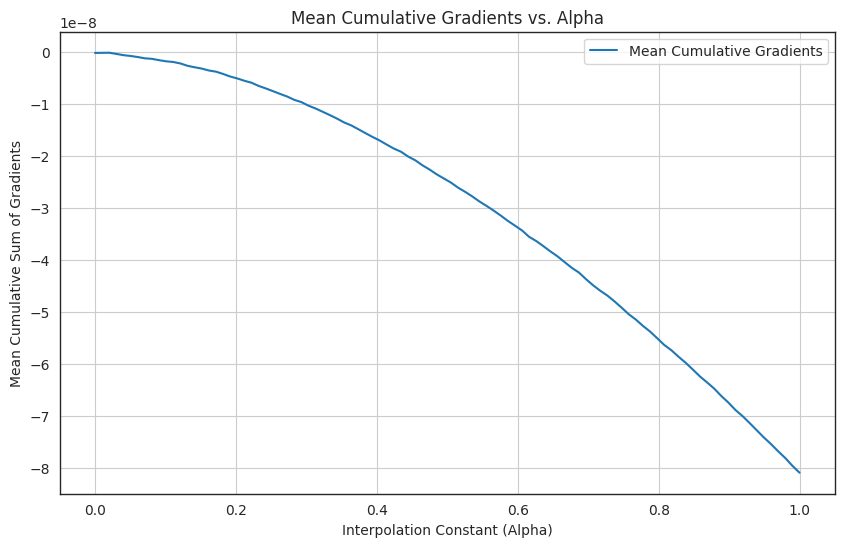

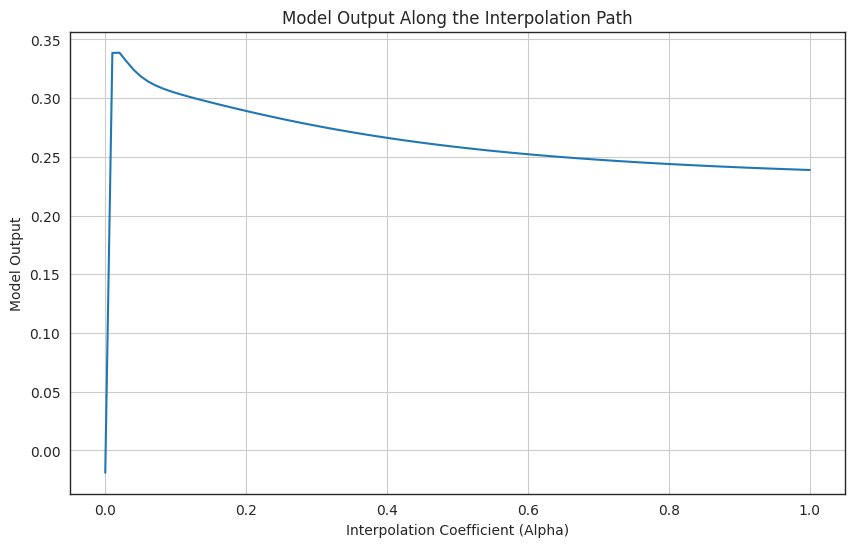

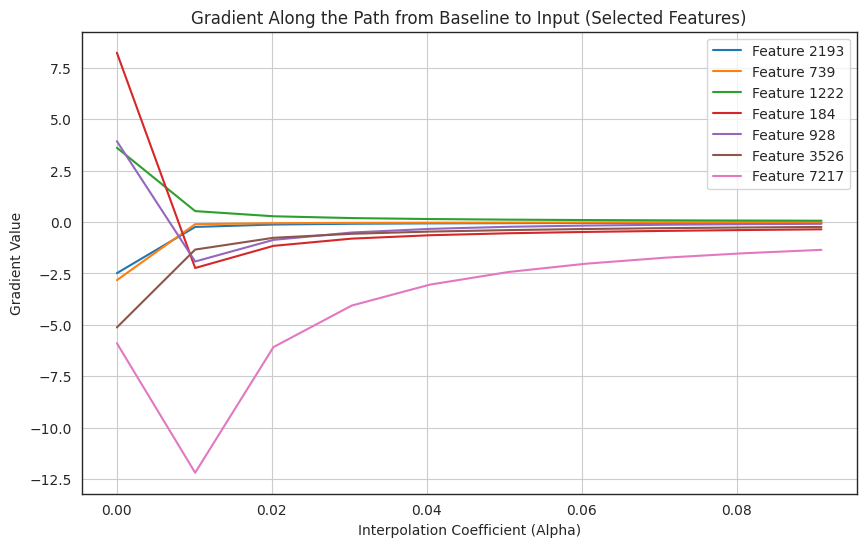

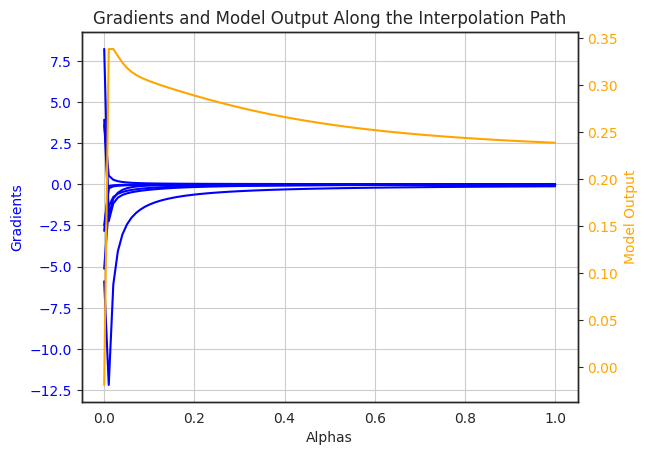

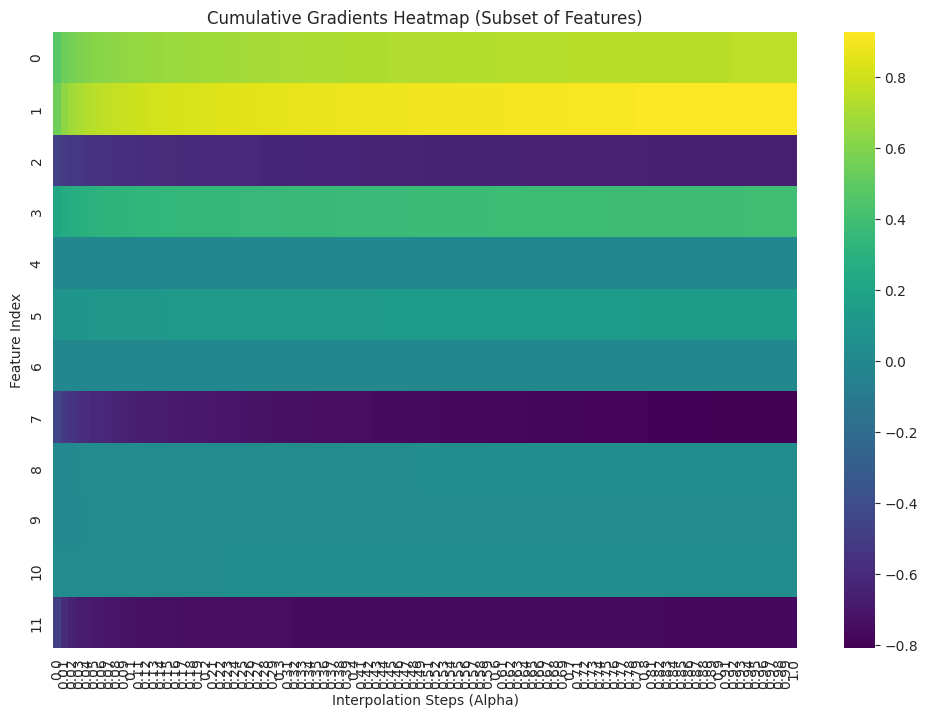

In [6]:
selected_features = [2193, 739, 1222, 184, 928, 3526, 7217]
plot_gradients_line_plot(alphas, gradients_tensor, cumulative_gradients, outputs, selected_features)

In [1]:
num_features = gradients_tensor.shape[1]
block_size = 100

# Loop through the features in blocks of 100
for start in range(0, num_features, block_size):
    end = min(start + block_size, num_features)
    features_to_show = np.arange(start, end)
    heatmap_data = gradients_tensor[:, features_to_show].numpy()
    
    plt.figure(figsize=(18, 12))
    sns.heatmap(heatmap_data.T, cmap='viridis', 
                xticklabels=np.round(alphas.numpy(), 2), yticklabels=features_to_show)
    # Adjust the number of ticks on the x-axis
    plt.xticks(ticks=np.linspace(0, len(alphas) - 1, num=10), labels=np.round(np.linspace(0, 1, num=10), 2))
    plt.xlabel('Interpolation Step')
    plt.ylabel('Feature Index')
    plt.title(f'Heatmap of Gradients Along the Interpolation Path (Features {start}-{end-1})')
    plt.show()
    

NameError: name 'gradients_tensor' is not defined

## Nfl Integrated Gradients

In [9]:
checkpoint_path_nfl = "/scratch/lcornelis/outputs/ray_results/TorchTrainer_2024-10-29_13-49-44/model=gat-v4,seed=47436_511_act=tanh,adj_thresh=0.9000,batch_size=8,dropout=0.1000,l1_lambda=0.0000,lr=0.0001,lr_scheduler=CosineA_2024-10-29_18-37-51/checkpoint_000342"
nfl_alphas, nfl_gradients_tensor, nfl_cumulative_gradients, nfl_outputs = compute_gradients_and_cumulative(checkpoint_path_nfl, steps=100)

Loading datasets from /scratch/lcornelis/data/data_louisa
Absolute path: /scratch/lcornelis/data/data_louisa
Directory contents: ['processed', 'raw']
Processed file names: ['ftd_y_val_nfl_adj_thresh_0.9_num_nodes_7258_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_train_nolog_random_state_42.pt', 'ftd_y_val_nfl_adj_thresh_0.9_num_nodes_7258_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_test_nolog_random_state_42.pt']
Loading data from: /scratch/lcornelis/data/data_louisa/processed/ftd_y_val_nfl_adj_thresh_0.9_num_nodes_7258_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_train_nolog_random_state_42.pt
Train dataset loaded successfully
Processed file names: ['ftd_y_val_nfl_adj_thresh_0.9_num_nodes_7258_mutation_GRN,MAPT,C9orf72,CTL_csf_sex_M,F_masternodes_False_sex_specific_False_train_nolog_random_state_42.pt', 'ftd_y_val_nfl_adj_thresh_0.9_num_nodes_7258_mutation_GRN,MAPT,C9orf72,CTL_csf_se

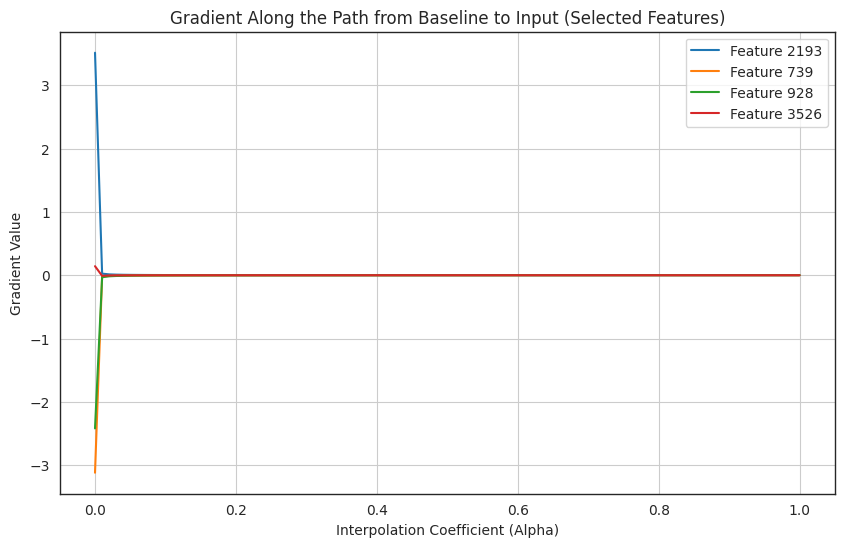

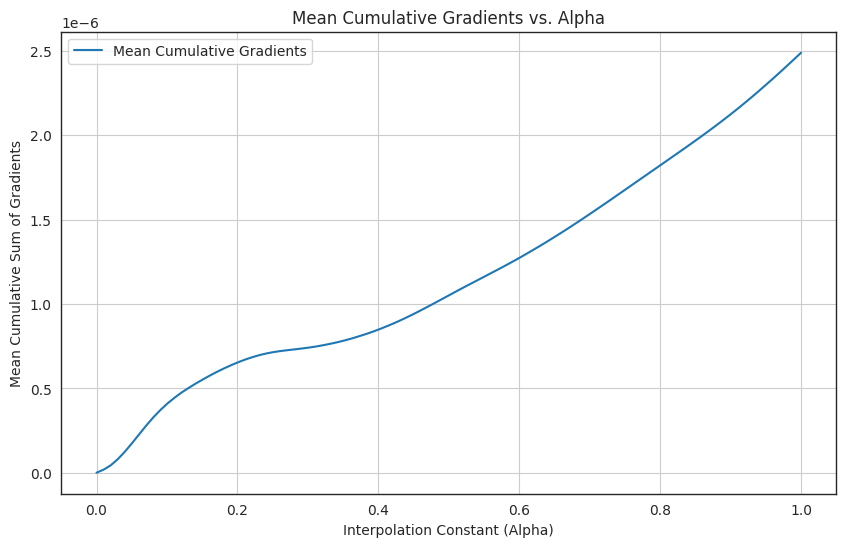

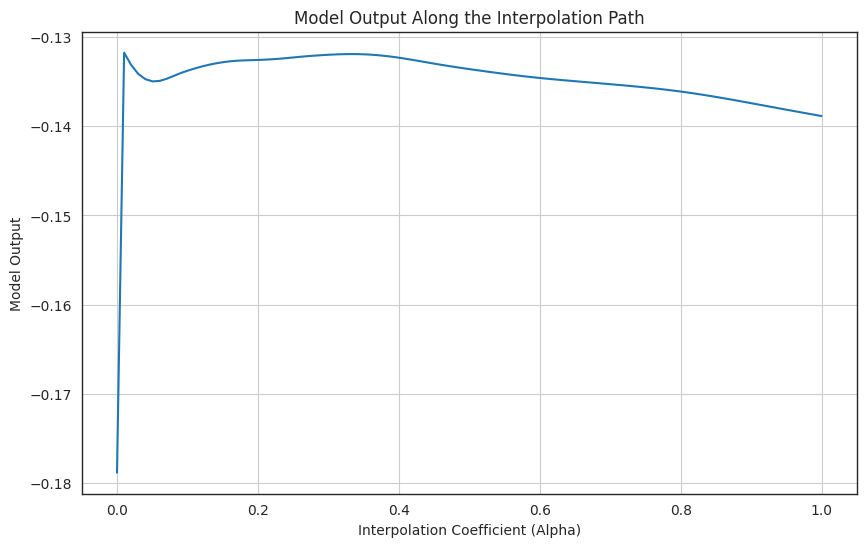

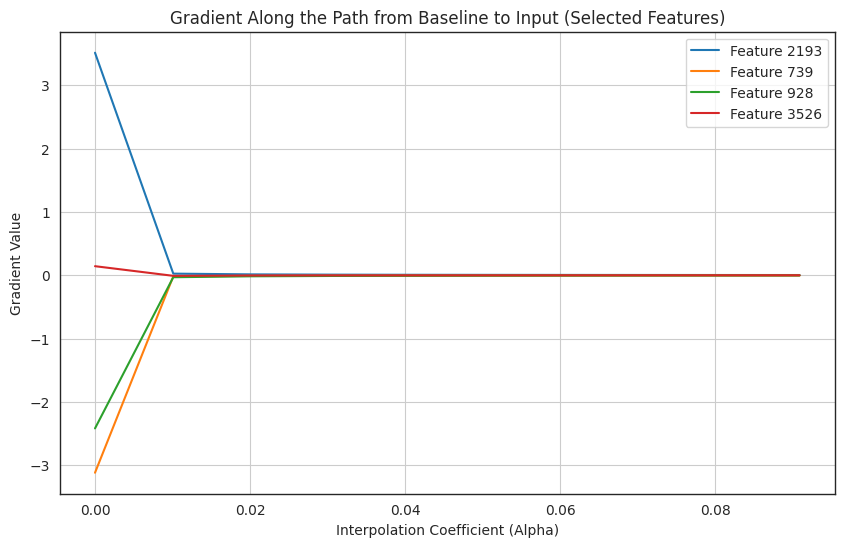

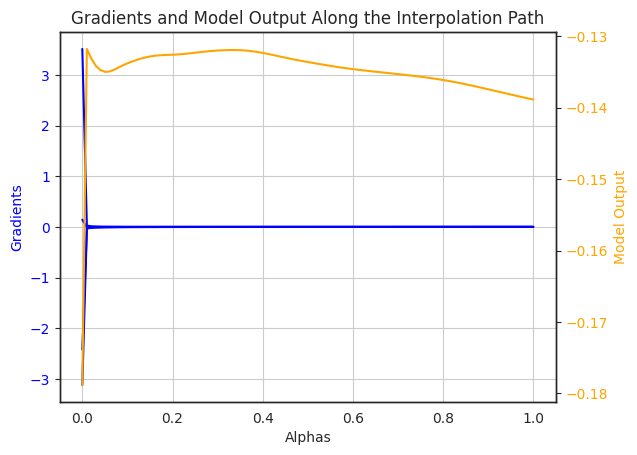

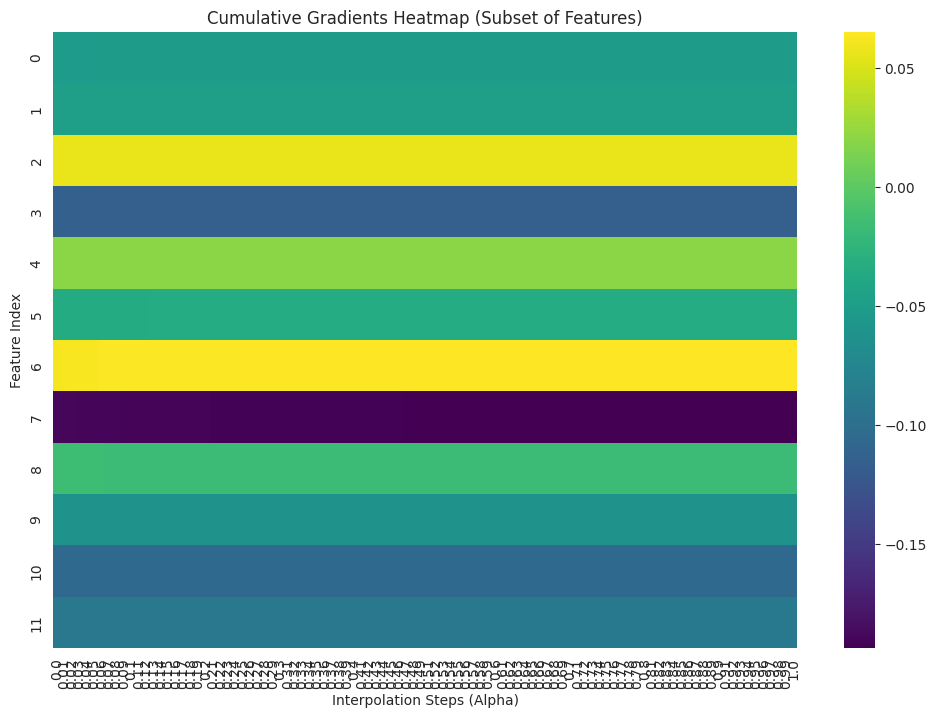

In [10]:
selected_features = [2193, 739, 928, 3526]
plot_gradients_line_plot(nfl_alphas, nfl_gradients_tensor, nfl_cumulative_gradients, nfl_outputs, selected_features)

In [10]:
num_features = nfl_gradients_tensor.shape[1]
block_size = 100

# Loop through the features in blocks of 100
for start in range(0, num_features, block_size):
    end = min(start + block_size, num_features)
    features_to_show = np.arange(start, end)
    heatmap_data = nfl_gradients_tensor[:, features_to_show].numpy()
    
    plt.figure(figsize=(18, 12))
    sns.heatmap(heatmap_data.T, cmap='viridis', 
                xticklabels=np.round(alphas.numpy(), 2), yticklabels=features_to_show)
    # Adjust the number of ticks on the x-axis
    plt.xticks(ticks=np.linspace(0, len(alphas) - 1, num=10), labels=np.round(np.linspace(0, 1, num=10), 2))
    plt.xlabel('Interpolation Step')
    plt.ylabel('Feature Index')
    plt.title(f'Heatmap of Gradients Along the Interpolation Path (Features {start}-{end-1})')
    plt.show()

NameError: name 'nfl_gradients_tensor' is not defined

## Visualizing Attention Coefficients